In [1]:
# %pip install scipy PyWavelets mne

In [2]:
# !pip install -q lightning

In [3]:
%matplotlib inline
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import stft, ricker, cwt, butter, iirnotch, lfilter
import scipy.stats as stats
import pywt
from tqdm import tqdm
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import mne # python package for processing and analyzing EEG/MEG data
from statsmodels.stats.weightstats import ztest
import wandb 
import pytorch_lightning as pl
from pytz import timezone
from datetime import datetime
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: page0526 (iai-uet-vnu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
mne.set_log_level(verbose='ERROR') # only log error message

# Dataset Processing



- Source: [P300 speller with ALS patients](http://bnci-horizon-2020.eu/database/data-sets)

- Paper: [Attention and P300-based BCI performance in people with amyotrophic lateral sclerosis](https://doi.org/10.3389/fnhum.2013.00732)





**Extract from the paper (Experimental protocol):**



Scalp EEG signals were recorded (g.MOBILAB, g.tec, Austria) from eight channels according to 10–10 standard (Fz, Cz, Pz, Oz, P3, P4, PO7 and PO8; Chatrian et al., 1985; Krusienski et al., 2006) using active electrodes (g.Ladybird, g.tec, Austria). All channels were referenced to the right earlobe and grounded to the left mastoid. The EEG signal was digitized at 256 Hz. Data acquisition and stimuli delivery were managed by the BCI2000 framework (Schalk et al., 2004).



Participants were required to copy spell seven predefined words of five characters each (runs), by controlling a P300 speller (Farwell and Donchin, 1988). The latter consisted of a 6 by 6 matrix containing alphanumeric characters (Figure 1A). Rows and columns on the interface were randomly intensified for 125 ms, with an inter stimulus interval (ISI) of 125 ms, yielding a 250 ms lag between the appearance of two stimuli (stimulus onset asynchrony, SOA). For each character selection (trial) all rows and columns were intensified 10 times (stimuli repetitions) thus each single item on the interface was intensified 20 times. Participants were seated facing a 15” computer screen placed at eye level approximately one meter in front of them. The angular distance subtended by the speller was of 15 degrees. A single flash of a letter at the beginning of each trial cued the target to focus. In the first three runs (15 trials in total) EEG data was stored to perform a calibration of the BCI classifier. Thus no feedback was provided to the participant up to this point. A stepwise linear discriminant analysis (SWLDA) was applied to the data from the three calibration runs (i.e., runs 1–3) to determine the classifier weights (i.e., classifier coefficients) (Krusienski et al., 2006). These weights were then applied during the subsequent four testing runs (i.e., testing set; runs 4–7) when participants were provided with feedback. EEG potentials between 0 and 800 ms after each stimulus onset were decimated by replacing each sequence of 12 samples with their mean value and used for the analysis. The next four runs (20 trials in total) characterized a testing phase in which feedback was provided by showing each spelled character. In cases of error the feedback was represented by a dot (instead of the wrongly typed character) to minimize frustration of the participants.

In [6]:
def load_data(filepath):
    """
    Loads EEG signal from the dataset
    """
    sample_matlab_data = scio.loadmat(filepath)  # Structured Matlab Array containing all information
    return sample_matlab_data

basedir = '/kaggle/input/eeg-p300-als'

In [7]:
patient_data = []
for file in os.listdir(basedir):
    filepath = os.path.join(basedir, file)
    patient_data.append(load_data(filepath))

print(len(patient_data))

8


## Processing data

In [8]:
def get_channel_name(patient, index):
    """
    Returns the name of the EEG channel for the corresponding index
    """
    return patient['data'][0][0]['channels'][0][index]
print(get_channel_name(patient_data[0], 1))

['Cz']


In [9]:
def get_channel_index(patient, channel_name):
    """
    Returns the index number of a channel
    """
    indices = [data[0].lower() for data in patient['data'][0][0]['channels'][0]]
    return indices.index(channel_name.lower())
print(get_channel_index(patient_data[0], 'Fz'))

0


In [10]:
print("Data shape")

print(f"Signal: {patient_data[0]['data'][0][0]['X'].shape}") # data points and number of channels (Fz, Cz, Pz, Oz, P3, P4, PO7, PO8)
print(f"Target/Class label: {patient_data[0]['data'][0][0]['y'].shape}") # target label
print(f"Stimulus type: {patient_data[0]['data'][0][0]['y_stim'].shape}") # stimulus type (visual/auditory)

Data shape
Signal: (347704, 8)
Target/Class label: (347704, 1)
Stimulus type: (347704, 1)


In [11]:
targets = np.unique(patient_data[0]['data'][0][0]['y']) # baseline/calibration, non-target, target
targets

array([0, 1, 2], dtype=uint8)

In [12]:
stimuluses = np.unique(patient_data[0]['data'][0][0]['y_stim'])
stimuluses

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int16)

### Parameters of the EEG Signal
total trials = 15

In [13]:
# Thông số
sample_frequency = 256 #Hz
bandpass_filter = (0, 30) # Hz, cho phép tín hiệu trong dải tần số (0, 30) ~ alpha, beta waves
stimulus_duration = 125 # ms, độ dài của 1 stimulus
interstimulus_interval = 125 # ms, khoảng cách giữa 2 stimulus liên tiếp
total_stimulus = 12 
stimulus_repetitions = 10 # trial: each character selection
total_stimulus_appeared_per_trial = total_stimulus * stimulus_repetitions

trial_duration = (stimulus_duration * total_stimulus_appeared_per_trial) + (interstimulus_interval * (total_stimulus_appeared_per_trial- 1))
samples_per_trial = (sample_frequency * trial_duration)//1000

print(f"Each trial duration: {trial_duration} ms or {samples_per_trial} samples")

Each trial duration: 29875 ms or 7648 samples


In [14]:
patient_data[0]['data'].shape

(1, 1)

In [15]:
patient_data[0]['data']

array([[(array([[array(['Fz'], dtype='<U2'), array(['Cz'], dtype='<U2'),
                array(['Pz'], dtype='<U2'), array(['Oz'], dtype='<U2'),
                array(['P3'], dtype='<U2'), array(['P4'], dtype='<U2'),
                array(['PO7'], dtype='<U3'), array(['PO8'], dtype='<U3')]],
              dtype=object), array([[  0.09289892,  -2.25390284,  -1.26008135, ...,  -1.07561955,
                -10.18247558,  -0.81632203],
               [  6.14215846,   4.14521837,   4.18222749, ...,   4.21605678,
                 -4.6256469 ,   8.38538104],
               [ 10.62365791,   9.14520778,   8.07406663, ...,   8.37235975,
                 -1.62721399,  15.35836645],
               ...,
               [ -9.5044938 , -10.62522418,  -9.15300037, ...,  -8.1721617 ,
                -29.91646304,  -0.30597058],
               [ -6.56928837,  -8.16272708,  -7.14593174, ...,  -6.97685362,
                -19.72338178,  -1.38797586],
               [ -2.85853089,  -4.88395374,  -4.22017997

In [16]:
def get_trials(sample, remove_calibration_data=True):
    """
    Returns all trial data for a patient
    """
    data = sample['data'][0][0]
    signal = data['X']
    stimulus = data['y_stim']
    target = data['y']

    x, y_stimulus, y_target = [], [], []
#     trial_start = 0
    for i in range(data['trial'].shape[1]):
        trial_start = data['trial'][0, i]
        trial_end = trial_start+samples_per_trial


        # Fetch signal
        x.append(signal[trial_start:trial_end])
        # Fetch stimulus
        y_stimulus.append(stimulus[trial_start:trial_end, 0])
        # Fetch target
        y_target.append(target[trial_start:trial_end, 0])

    x, y_stimulus, y_target = np.array(x), np.array(y_stimulus), np.array(y_target)
    if remove_calibration_data:
        x, y_stimulus, y_target = x[3:], y_stimulus[3:], y_target[3:]
    return x, y_stimulus, y_target

X, y_stim, y_target = get_trials(patient_data[0])
print(X.shape, y_stim.shape, y_target.shape)
print(np.unique(y_stim))
print(np.unique(y_target))

(32, 7648, 8) (32, 7648) (32, 7648)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2]


In [17]:
number_of_trials_per_run = 5 # each run is a word and each trial is a character of the word
number_of_runs = 7 # total number of words

total_characters_with_calibration = number_of_trials_per_run * number_of_runs
total_characters_without_calibration = number_of_trials_per_run * number_of_runs - 3

def get_dataset(dataset):
    """
    Converts the matlab file of all patients to a single numpy array and returns the dataset
    Returns: Numpy array -> input shape: (patient_id, run, trial, sample, channels),
             stimulus -> (patient_id, run, trial, sample)
             target -> (patient_id, run, trial, sample)
    """
    x, y_stim, y_target = [], [], []
    for i in range(len(dataset)):
        patient = dataset[i]
        x_trial, y_stim_trial, y_target_trial = get_trials(patient, remove_calibration_data=False)

        # Reshape array to group trials by run
        x_trial = x_trial.reshape(-1, number_of_trials_per_run, x_trial.shape[1], x_trial.shape[2])
        y_stim_trial  = y_stim_trial.reshape(-1, number_of_trials_per_run, y_stim_trial.shape[1])
        y_target_trial = y_target_trial.reshape(-1, number_of_trials_per_run, y_target_trial.shape[1])

        # Add to array
        x.append(x_trial)
        y_stim.append(y_stim_trial)
        y_target.append(y_target_trial)

    return np.array(x), np.array(y_stim), np.array(y_target)


X, y_stim, y_target = get_dataset(patient_data)

print(X.shape, y_stim.shape, y_target.shape)
print(np.unique(y_stim))
print(np.unique(y_target))

(8, 7, 5, 7648, 8) (8, 7, 5, 7648) (8, 7, 5, 7648)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2]


### Mapping for row/column value to character

In [18]:
words =np.array([chr(i) for i in range(ord('A'), ord('Z')+1)] + [str(i) for i in range(1, 10)] + ['-']) 
word_matrix = np.reshape(words, (6, 6)) # tạo cái bảng giống P300 Speller
word_matrix_row = np.arange(7, 13)
word_matrix_column = np.arange(1, 7)
print(word_matrix)
word_to_tup = {}
tup_to_word = {}

for i in range(word_matrix.shape[0]):
    for j in range(word_matrix.shape[1]):
        tup = (word_matrix_row[i], word_matrix_column[j])
        word_to_tup[word_matrix[i, j]] = tup
        tup_to_word[str(tup[0]) + "," + str(tup[1])] = word_matrix[i, j]



print("\nCharacter to indices")
print(word_to_tup)
print("\n Indices to Characters")
print(tup_to_word)

[['A' 'B' 'C' 'D' 'E' 'F']
 ['G' 'H' 'I' 'J' 'K' 'L']
 ['M' 'N' 'O' 'P' 'Q' 'R']
 ['S' 'T' 'U' 'V' 'W' 'X']
 ['Y' 'Z' '1' '2' '3' '4']
 ['5' '6' '7' '8' '9' '-']]

Character to indices
{'A': (7, 1), 'B': (7, 2), 'C': (7, 3), 'D': (7, 4), 'E': (7, 5), 'F': (7, 6), 'G': (8, 1), 'H': (8, 2), 'I': (8, 3), 'J': (8, 4), 'K': (8, 5), 'L': (8, 6), 'M': (9, 1), 'N': (9, 2), 'O': (9, 3), 'P': (9, 4), 'Q': (9, 5), 'R': (9, 6), 'S': (10, 1), 'T': (10, 2), 'U': (10, 3), 'V': (10, 4), 'W': (10, 5), 'X': (10, 6), 'Y': (11, 1), 'Z': (11, 2), '1': (11, 3), '2': (11, 4), '3': (11, 5), '4': (11, 6), '5': (12, 1), '6': (12, 2), '7': (12, 3), '8': (12, 4), '9': (12, 5), '-': (12, 6)}

 Indices to Characters
{'7,1': 'A', '7,2': 'B', '7,3': 'C', '7,4': 'D', '7,5': 'E', '7,6': 'F', '8,1': 'G', '8,2': 'H', '8,3': 'I', '8,4': 'J', '8,5': 'K', '8,6': 'L', '9,1': 'M', '9,2': 'N', '9,3': 'O', '9,4': 'P', '9,5': 'Q', '9,6': 'R', '10,1': 'S', '10,2': 'T', '10,3': 'U', '10,4': 'V', '10,5': 'W', '10,6': 'X', '11,1': '

In [19]:
target_class = 2
non_target_class = 1

def convert_stimulus_to_word(y_stim, y_target):
    """
    Takes all consecutive stimulus (row & column number of BCI) and outputs the corresponding word that was
    displayed.
    Input shape: (Patients, run, trial, samples)
    Output shape: (Patients, run, trial, character)
    """

    y_stim = y_stim.reshape(-1)
    y_target = y_target.reshape(-1)
    target_stimulus = y_stim[y_target == target_class ]
    vals = []
    for i in range(len(target_stimulus)):
        if len(vals) == 0 or  vals[-1] != target_stimulus[i]:
            vals.append(target_stimulus[i])
    
    character_indices = []
    characters = []

    for i in range(0, len(vals)-1, 2):
        c = vals[i]
        r = vals[i+1]
        character_indices.append((r, c))
        characters.append(tup_to_word[str(r) + "," + str(c)])

    
    non_repeating_chars = []
    for c in characters:
        if len(non_repeating_chars) == 0 or non_repeating_chars[-1] != c:
            non_repeating_chars.append(c)



    words = []
    for i in range(0, len(non_repeating_chars), 5):
        words.append(''.join(non_repeating_chars[i:i+5]))
    return words



for i in range(X.shape[0]):
    print(f"Words displayed to patient: {i+1}")
    print(convert_stimulus_to_word(y_stim[0], y_target[0]))
    

Words displayed to patient: 1
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 2
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 3
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 4
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 5
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 6
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 7
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']
Words displayed to patient: 8
['WGAMN', 'F7ODY', 'KPUAB', 'AJOCY', 'IJYVN', 'O6A7Y', 'GPD']


In [20]:
y_stim[7].shape

(7, 5, 7648)

# High level overview of the dataset



First we will visualize the EEG signals collected from different patients. We will do a visual inspection to see some of the characteristics of the dataset e.g. what are the minimum and maximum amplitude of the signals for different patients, are there any visible artifacts in the signal, etc.

In [21]:
get_channel_index(patient_data[0], 'PO7')

6

In [22]:
def view_signal(signal, title='', channels_to_show=[], highpass=None, lowpass=None, y=None, scalings='auto'):
    signal = signal.reshape(-1, signal.shape[-1]).transpose()
    channels = ['P3', 'PO7', 'Fz', 'Cz', 'Pz', 'Oz', 'P4', 'PO8']
    channel_indices = [get_channel_index(patient_data[0], name) for name in channels]

    if len(channels_to_show) == 0:
        channels_to_show = [i for i in range(len(channels))]
    else:
        channels_to_show = [channels.index(channel) for channel in channels_to_show]

    info = mne.create_info(channels, sample_frequency, ch_types='eeg')
    data = mne.io.RawArray(signal[channel_indices, :], info)

    target_descriptions = ['No stimulus', 'Non-Target', 'Target']
    target_description_indices = {i:target_descriptions[i] for i in range(len(target_descriptions))}
    target_description_names = {target_descriptions[i]: i for i in range(len(target_descriptions))}

    if not (y is None):
        y = y.reshape(-1)
        target = np.where(y == target_description_names['Target'])[0]
        non_targets = np.where(y == target_description_names['Non-Target'])[0]
        onsets = []
        duration = []
        description = []

        for i in range(len(target)):
            if i == 0:
                onsets.append(target[i])
                description.append('T')
            else:
                if target[i] != target[i-1]+1:
                    duration.append(target[i-1] - onsets[-1])
                    onsets.append(target[i])
                    description.append('T')
                elif i == len(target) - 1:
                    duration.append(target[i] - onsets[-1])

        for i in range(len(non_targets)):
            if i == 0:
                onsets.append(non_targets[i])
                description.append('N')
            else:
                if non_targets[i] != non_targets[i-1]+1:
                    duration.append(non_targets[i-1] - onsets[-1])
                    onsets.append(non_targets[i])
                    description.append('N')
                elif i == len(non_targets) - 1:
                    duration.append(non_targets[i] - onsets[-1])

        onsets = np.array(onsets)/sample_frequency
        duration = np.array(duration)/sample_frequency

        data.set_annotations(mne.Annotations(onsets, duration, description))

    mne.set_config('MNE_BROWSE_RAW_SIZE','14,8') 
    data.plot(scalings=scalings, title=title, order=channels_to_show, highpass=highpass, lowpass=lowpass)

Patient 1


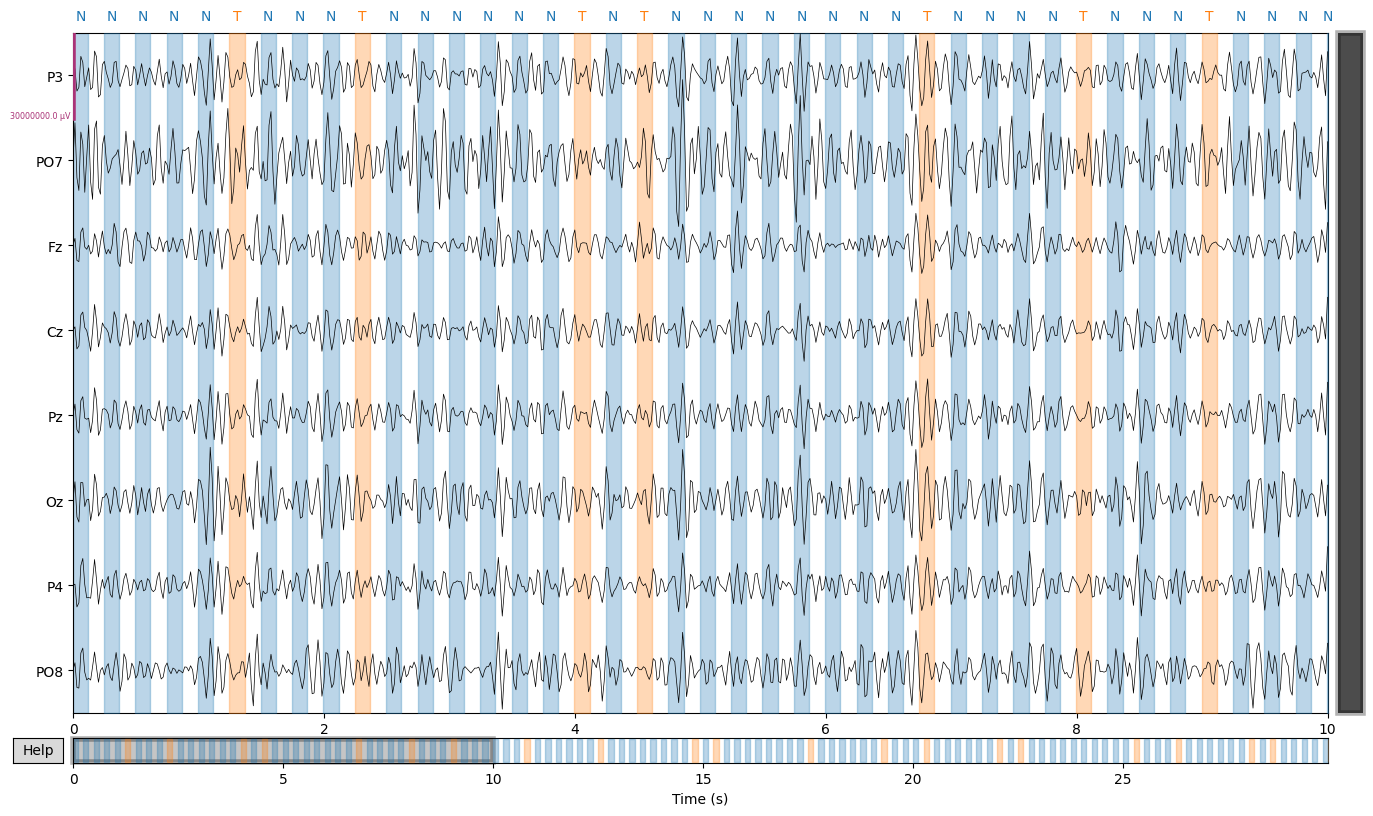

Patient 2


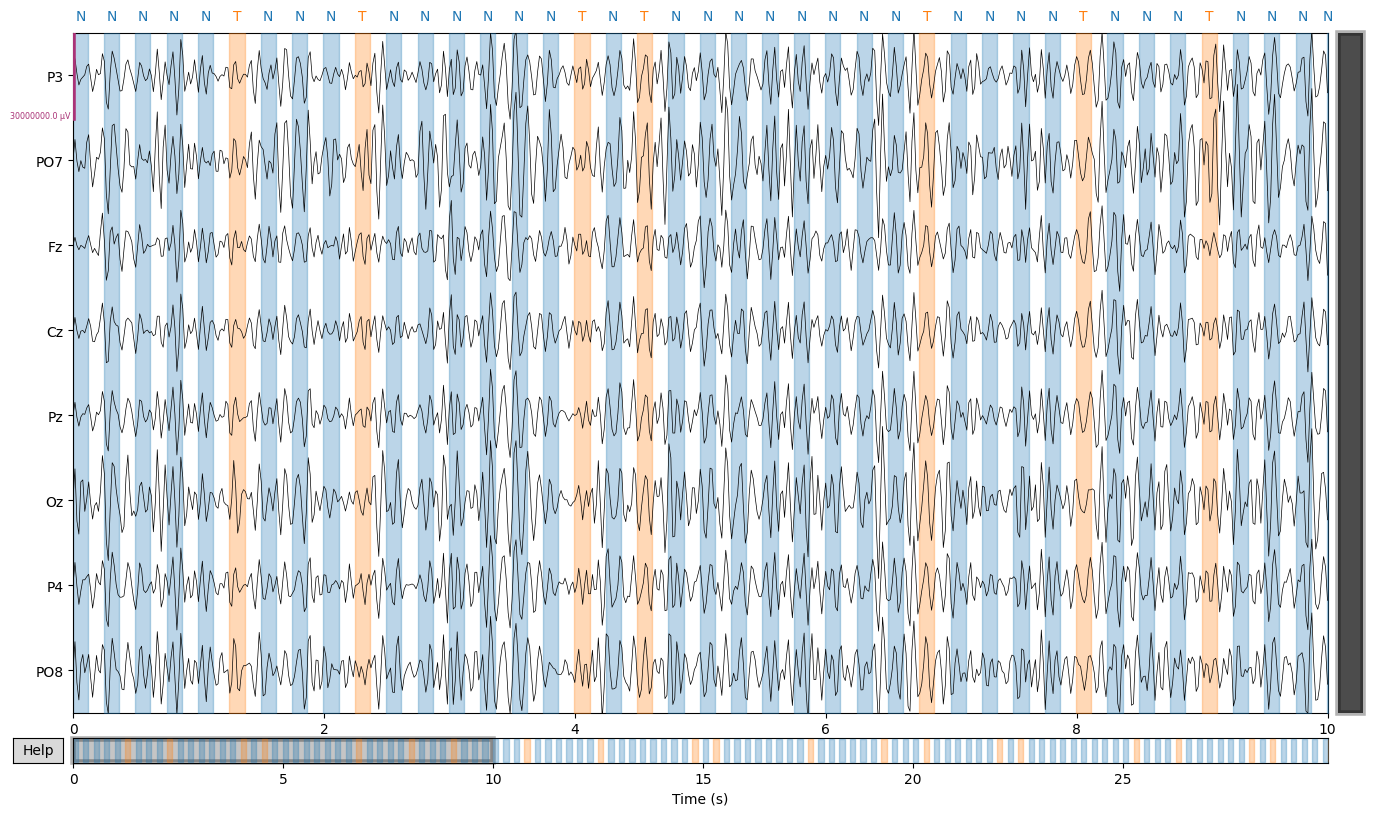

Patient 3


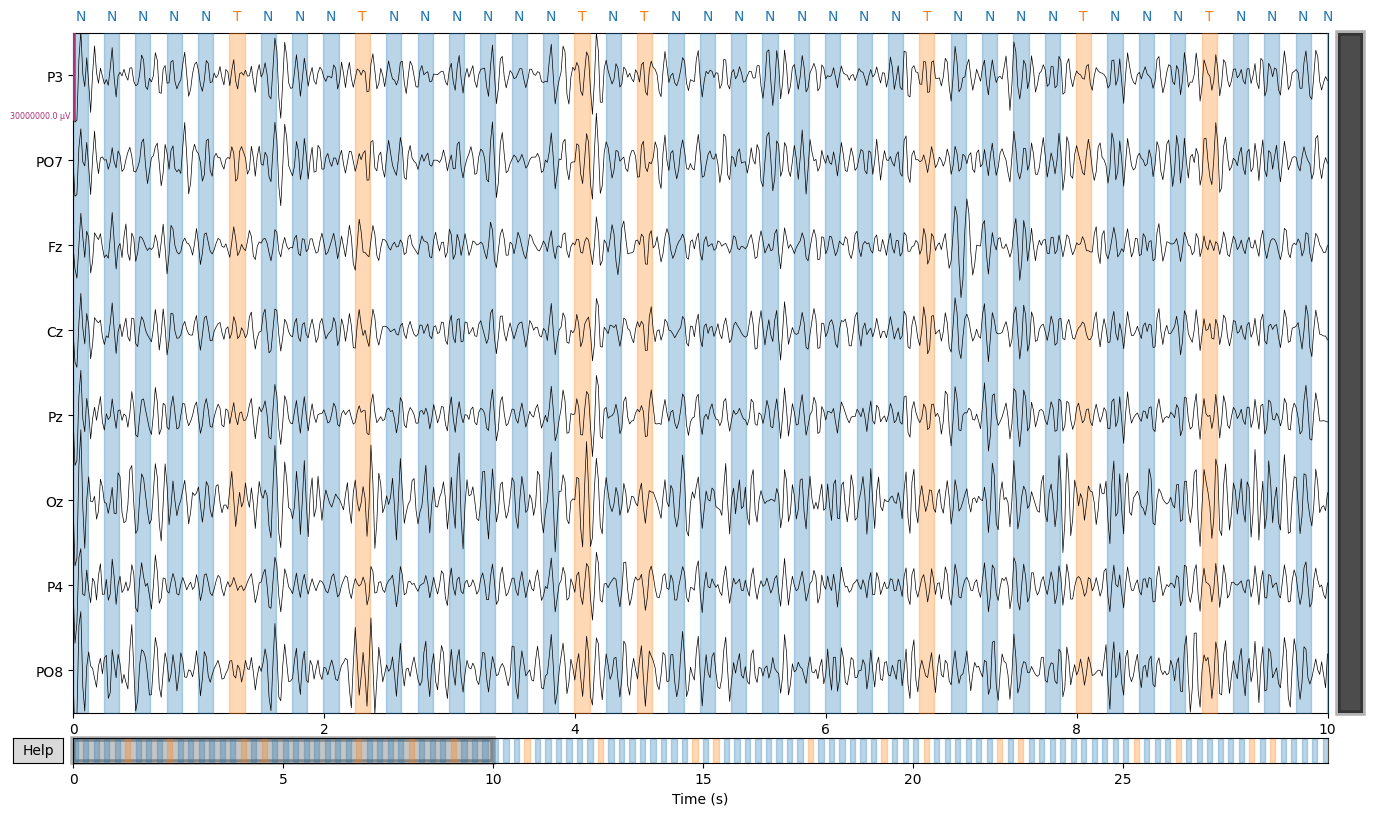

Patient 4


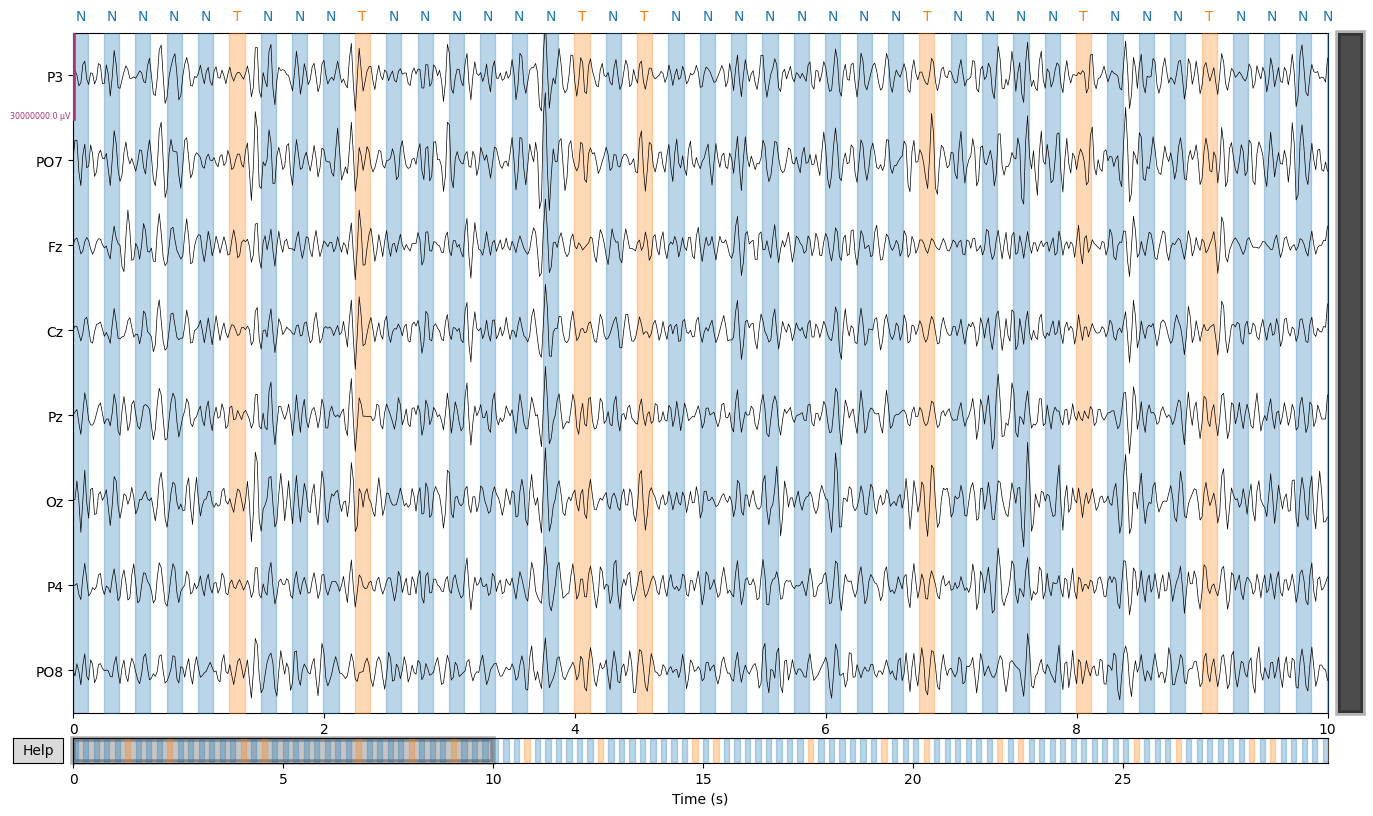

Patient 5


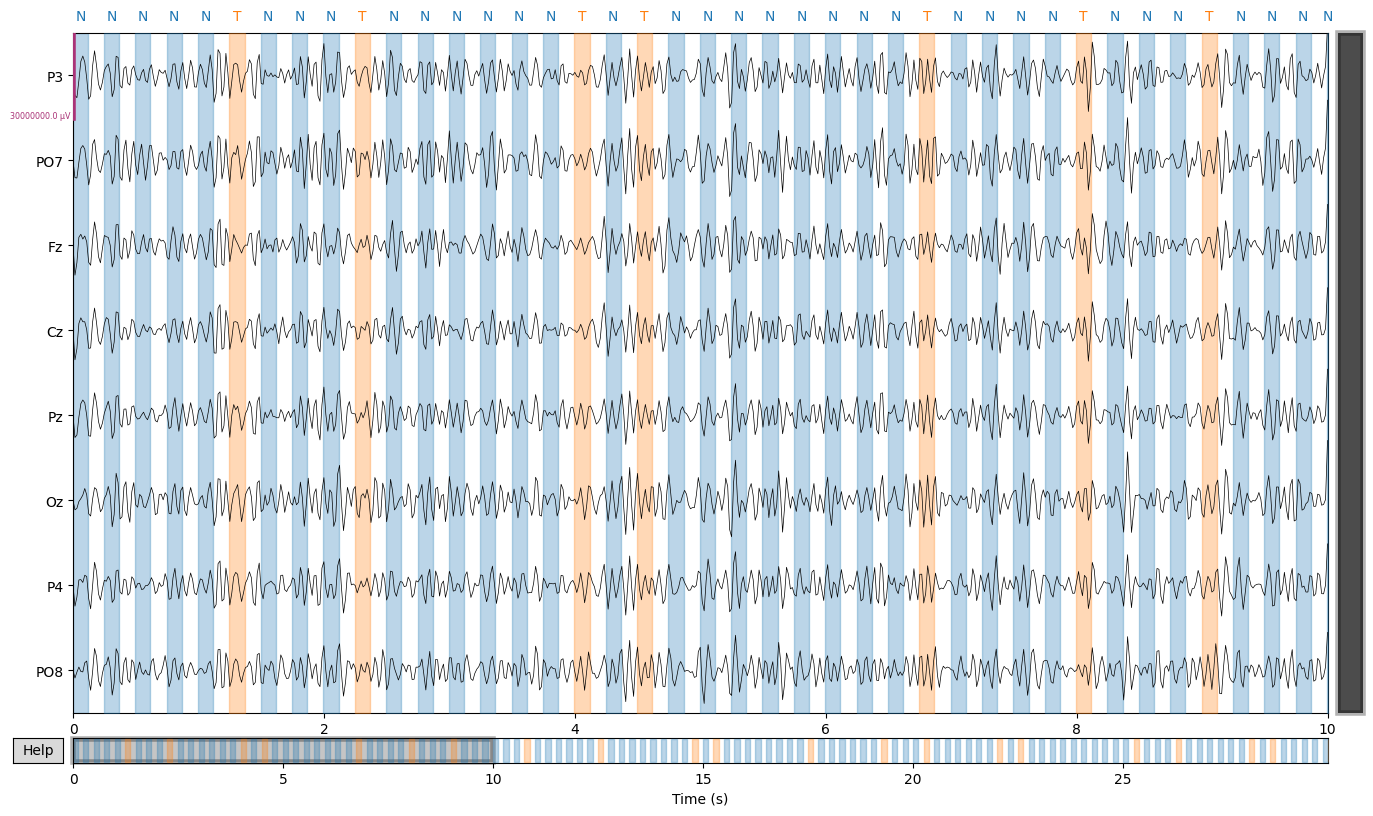

Patient 6


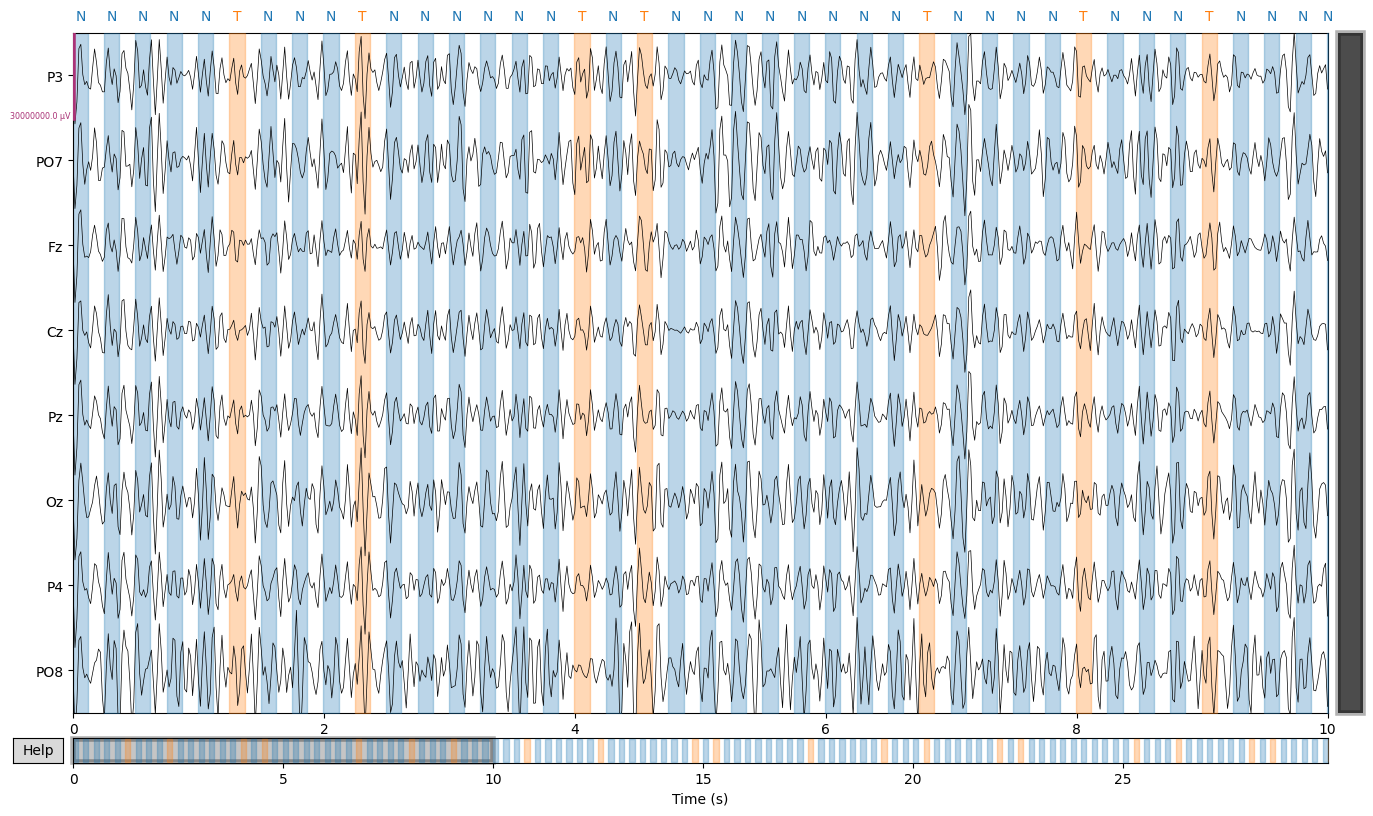

Patient 7


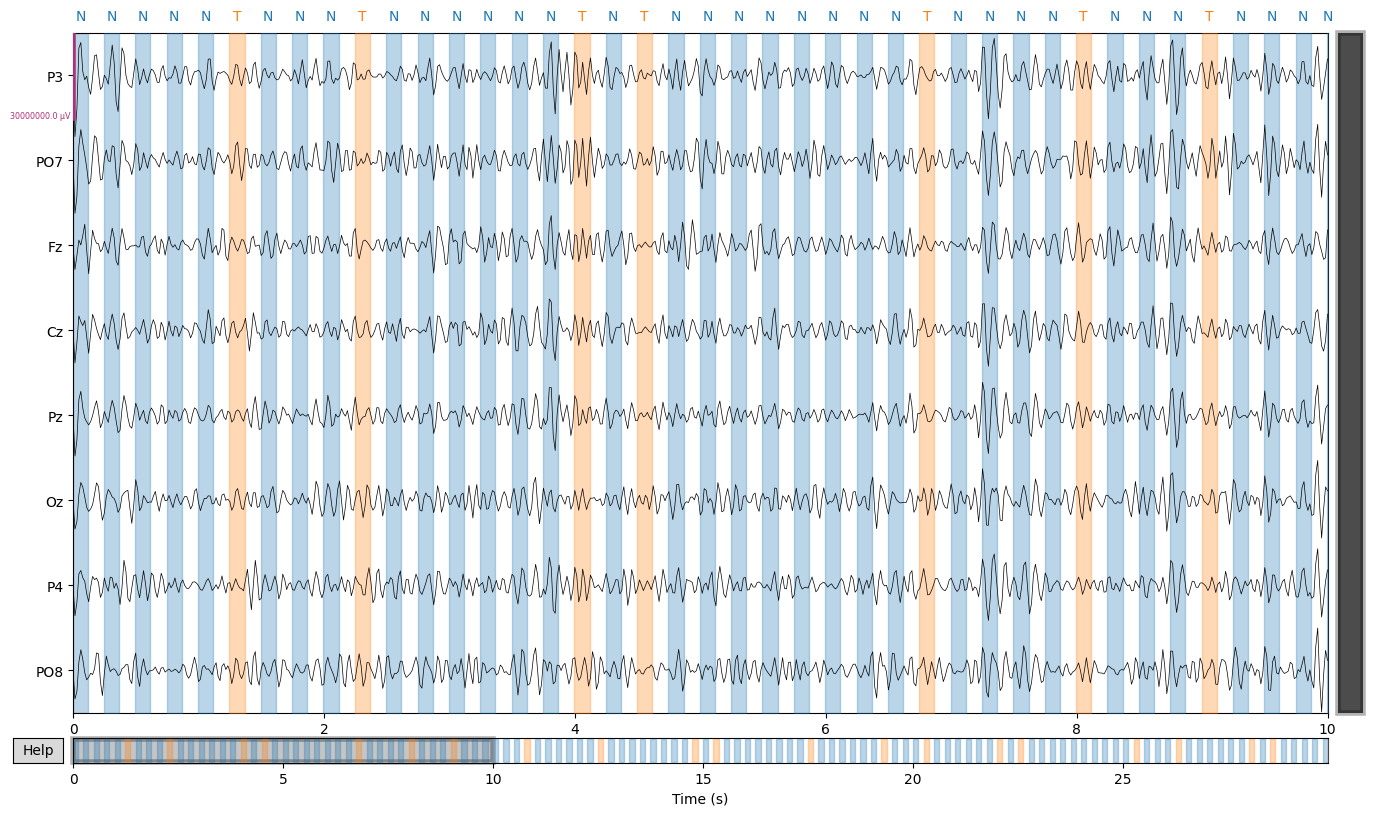

Patient 8


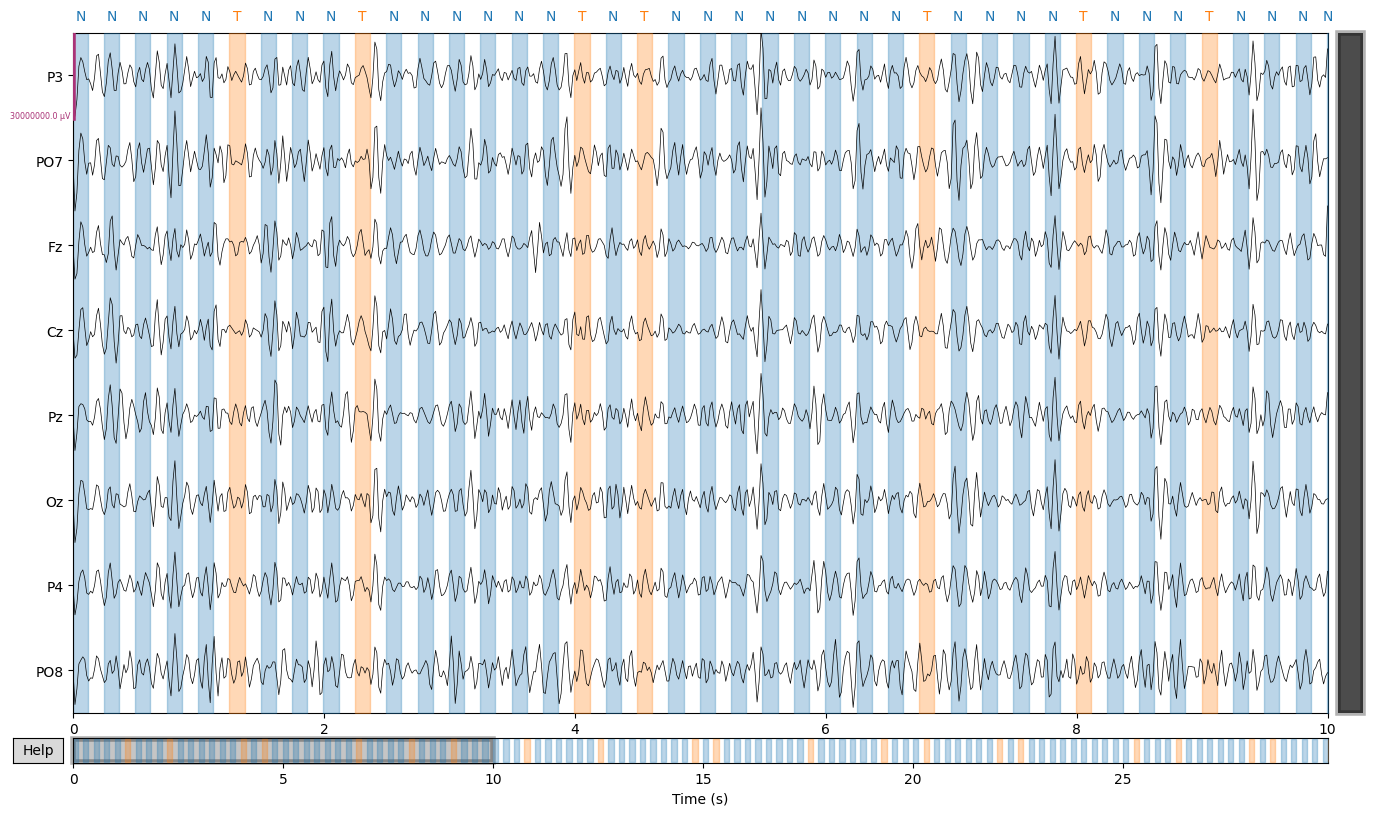

In [23]:
for i in range(X.shape[0]):
    print(f"Patient {i+1}")
    view_signal(X[i, 0, 0, :, :], title=f'Patient {i+1}', lowpass=20, highpass=8, y=y_target[i], scalings=dict(eeg=15))

In [24]:
X.shape, y_target.shape

((8, 7, 5, 7648, 8), (8, 7, 5, 7648))

## Removing Artifacts - Part I

In this section we will follow the same procedure mentioned in the paper to remove the artifacts and visualize the EEG signal.

**Extract from the paper (Data Analysis):**


EEG data was high pass and low pass filtered with cut off frequencies of 0.1 Hz and 10 Hz respectively using a 4th order Butterworth filter. In addition, a notch filter was used to remove 50 Hz contamination due to the AC interference. Data was divided into 1000 ms long epochs starting with the onset of each stimulus. Epochs in which peak amplitude was higher than 70 μV or lower than −70 μV were identified as artifacts and removed. A baseline correction was done based on the average EEG activity within 200 ms immediately preceding each epoch. The average waveform for both target and non-target epochs was computed for each trial in order to assess P300 peak amplitude. Particularly, amplitude of the P300 potential in Cz was defined as the highest value of the difference between target and non-target average waveforms in the time interval 250–700 ms

**Notch filter:** loại bỏ các tần số cụ thể, ví dụ như nhiễu từ dòng điện xoay chiều (50/60 Hz)

**Baseline correction (Hiệu chỉnh đường cơ sở):**: chuẩn hóa các epoch về cùng một thang đo,  

/tmp/ipykernel_874/3486399626.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), label=f'Order {order}')


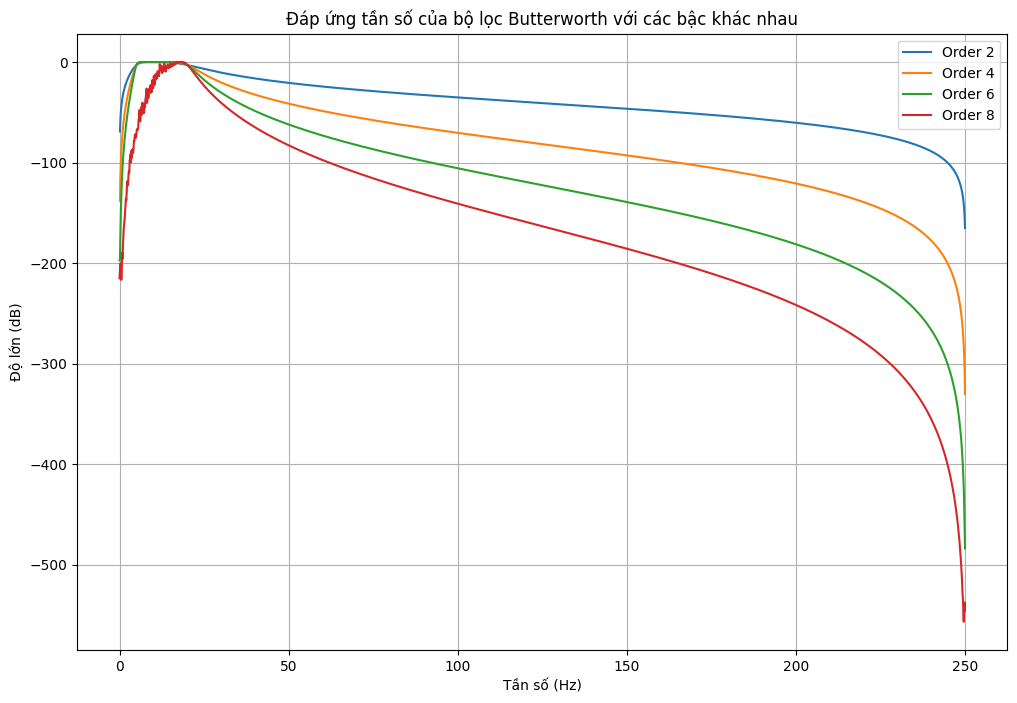

In [25]:
import numpy as np
from scipy.signal import butter, freqz
import matplotlib.pyplot as plt

fs = 500  # Tần số lấy mẫu (Hz)
lowcut = 5  # Tần số cắt thấp
highcut = 20  # Tần số cắt cao

# Tạo bộ lọc Butterworth với các bậc khác nhau
orders = [2, 4, 6, 8]
plt.figure(figsize=(12, 8))

for order in orders:
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    w, h = freqz(b, a, worN=2000, fs=fs)
    plt.plot(w, 20 * np.log10(abs(h)), label=f'Order {order}')

plt.title('Đáp ứng tần số của bộ lọc Butterworth với các bậc khác nhau')
plt.xlabel('Tần số (Hz)')
plt.ylabel('Độ lớn (dB)')
plt.grid()
plt.legend()
plt.show()

In [26]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    # order: độ dốc của đáp ứng tần số trong vùng chuyển tiếp từ dải thông (passband) sang stopband
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4, axis=-1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)

    return y

def notch_filter(data, frequency, fs, axis=-1, quality_factor=30.0):
    b, a = iirnotch(frequency, quality_factor, fs)
    return lfilter(b, a, data, axis=axis)

In [27]:
highpass_filter = 0.1 #Hz
lowpass_filter = 10 #Hz
notch_frequency = 50 #Hz

**Filter the signal**

In [28]:
X_filtered = butter_bandpass_filter(X, highpass_filter, lowpass_filter, sample_frequency, order=4, axis=3)
X_filtered = notch_filter(X_filtered, notch_frequency, sample_frequency, axis=3)
print(X_filtered.shape)

(8, 7, 5, 7648, 8)


**Remove amplitude greater than 70uV or less than -70uv**

In [29]:
minimum_amplitude = -70

maximum_amplitude = 70



X_filtered[(X_filtered < minimum_amplitude) | (X_filtered > maximum_amplitude)] = 0

print(X_filtered.shape)

(8, 7, 5, 7648, 8)


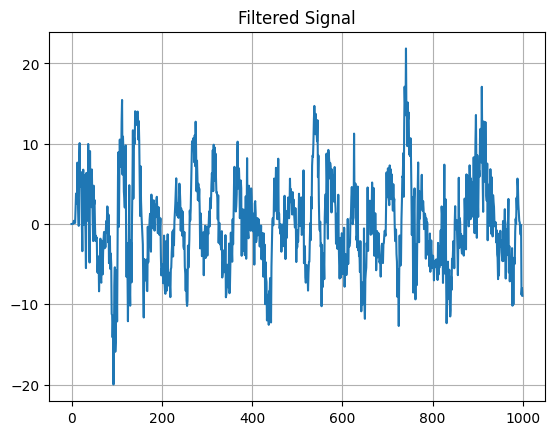

In [30]:
plt.figure()
plt.title("Filtered Signal")
plt.plot(X_filtered.reshape((X_filtered.shape[0], -1, X_filtered.shape[1]))[1, :1000, 0])
plt.grid()
plt.show()

**Baseline correction**

In [31]:
baseline_duration = 200 #ms
baseline_samples = int(sample_frequency*baseline_duration/1000)
epoch_duration = 1000 #ms
epoch_samples = int(sample_frequency*epoch_duration/1000)

X_filtered = X_filtered.reshape((X_filtered.shape[0], -1, X_filtered.shape[-1]))
y_filtered = y_target.reshape((y_target.shape[0], -1))

for patient in range(X_filtered.shape[0]):
    for channel in range(X_filtered.shape[-1]):
        i = 0
        while i < X_filtered.shape[1]:
            if y_filtered[patient, i] != 0: # Stimulus onset
                average = 0
                if i > baseline_samples:
                    average = np.mean(X_filtered[patient, i-baseline_samples:i+epoch_samples, channel])
                X_filtered[patient, i:i+epoch_samples, channel] = X_filtered[patient, i:i+epoch_samples, channel] - average
                i = i + epoch_samples
            else:
                i += 1
del y_filtered
X_filtered = X_filtered.reshape(X.shape)
print(X_filtered.shape)

(8, 7, 5, 7648, 8)


Patient 1


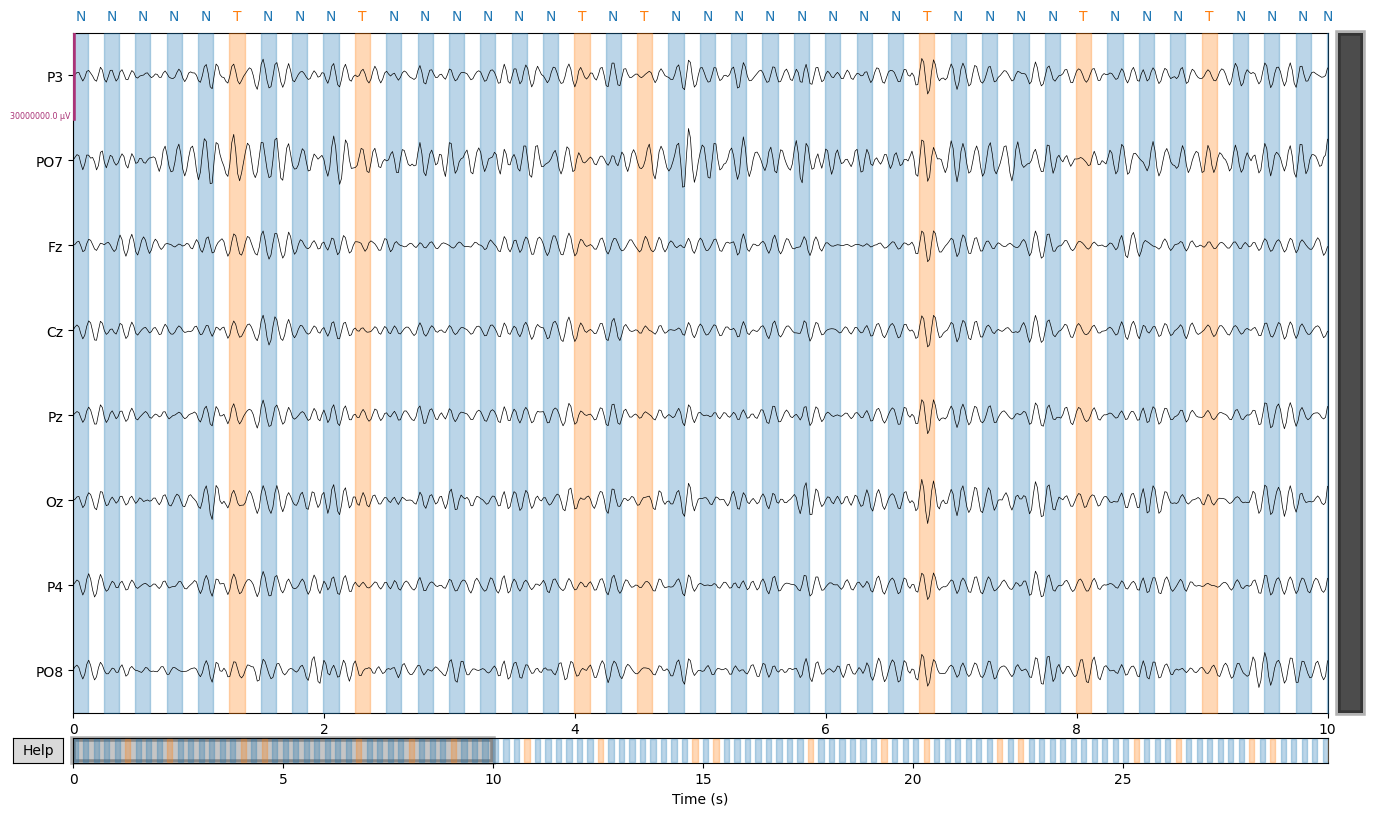

Patient 2


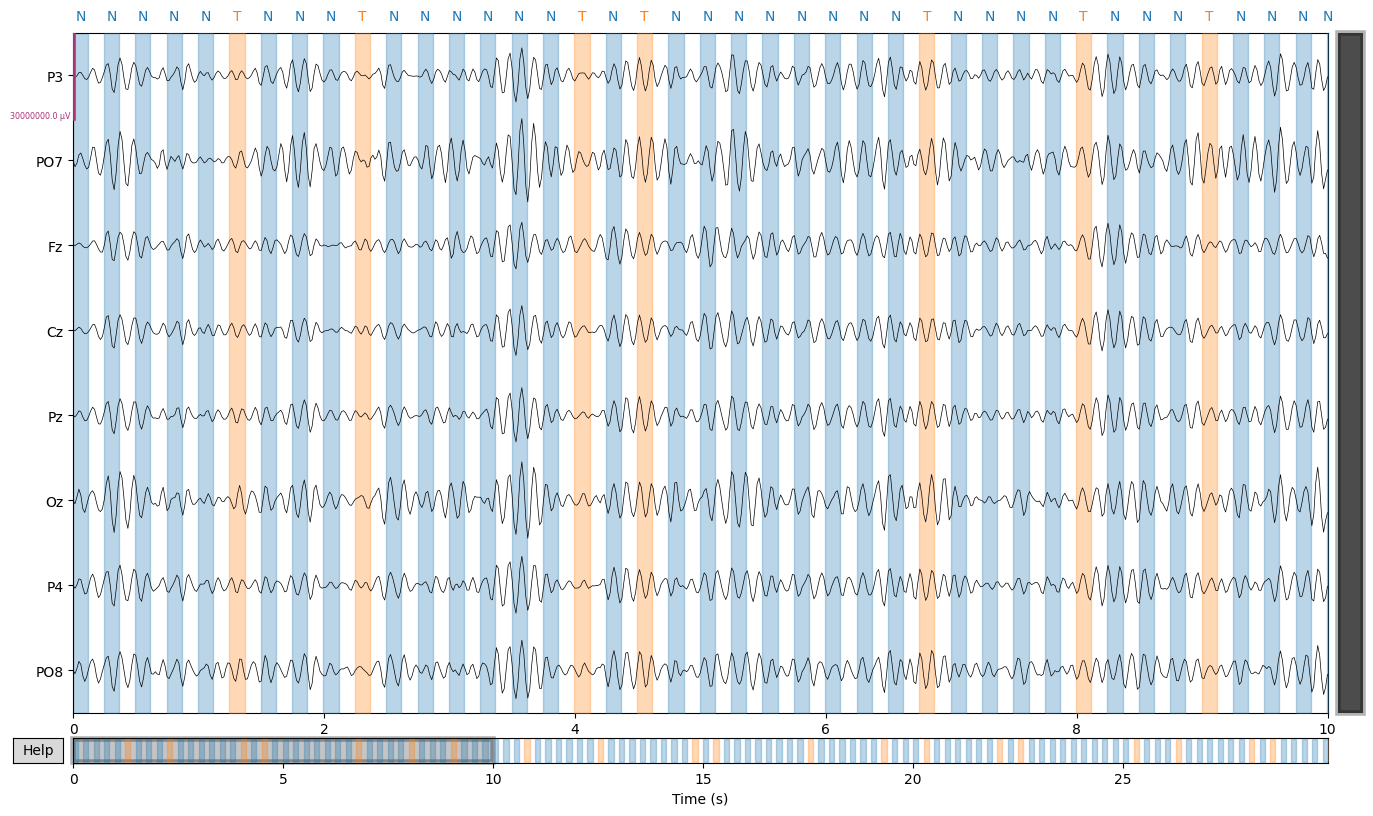

Patient 3


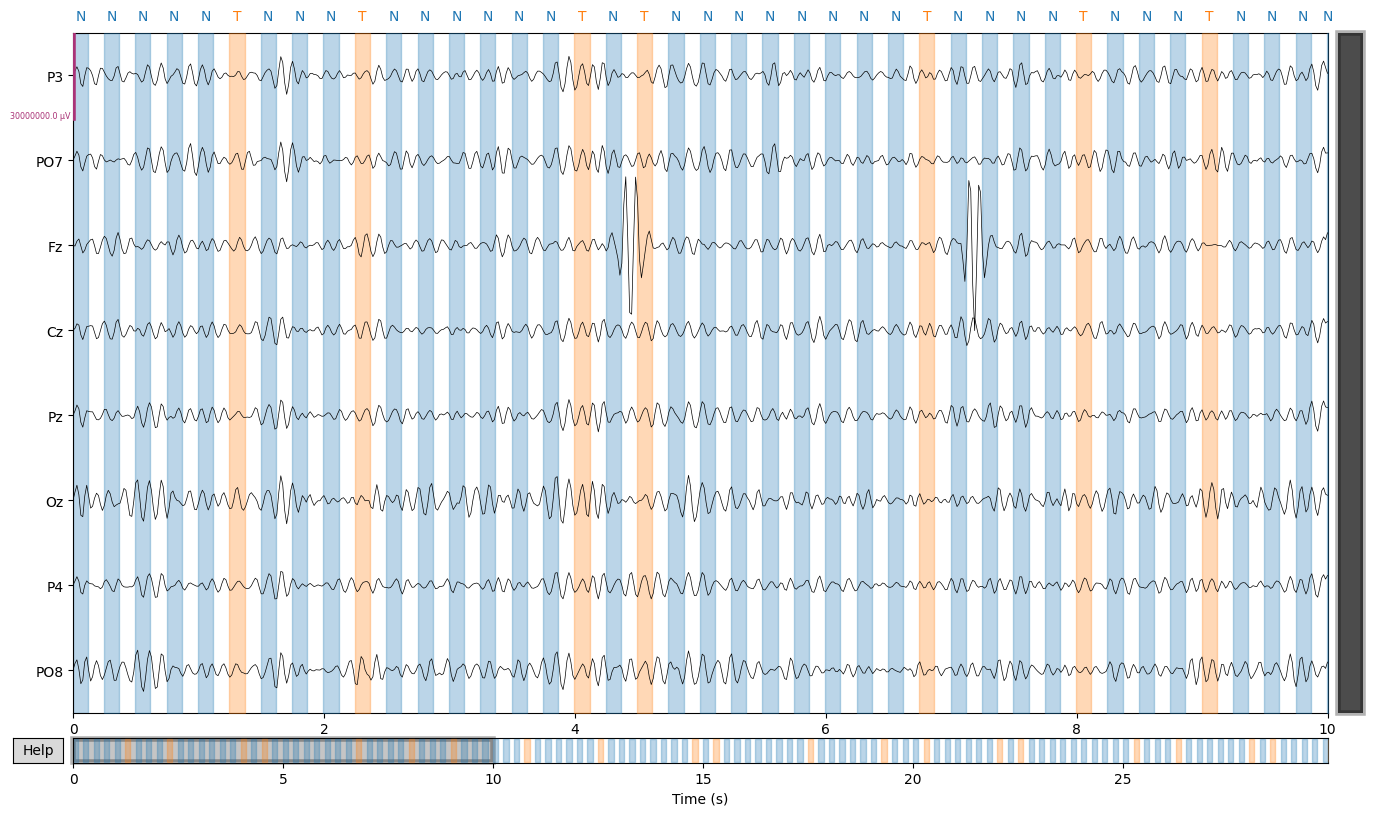

Patient 4


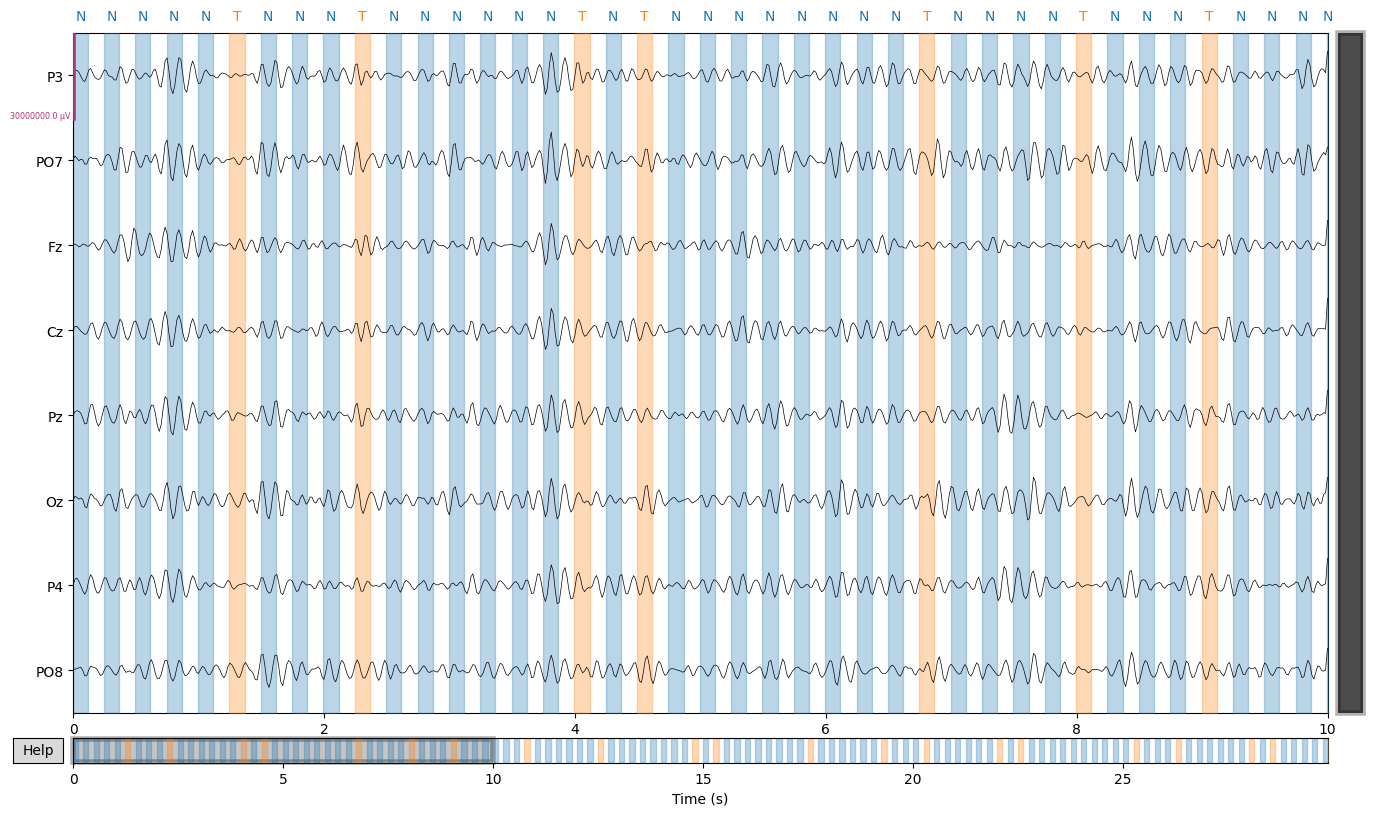

Patient 5


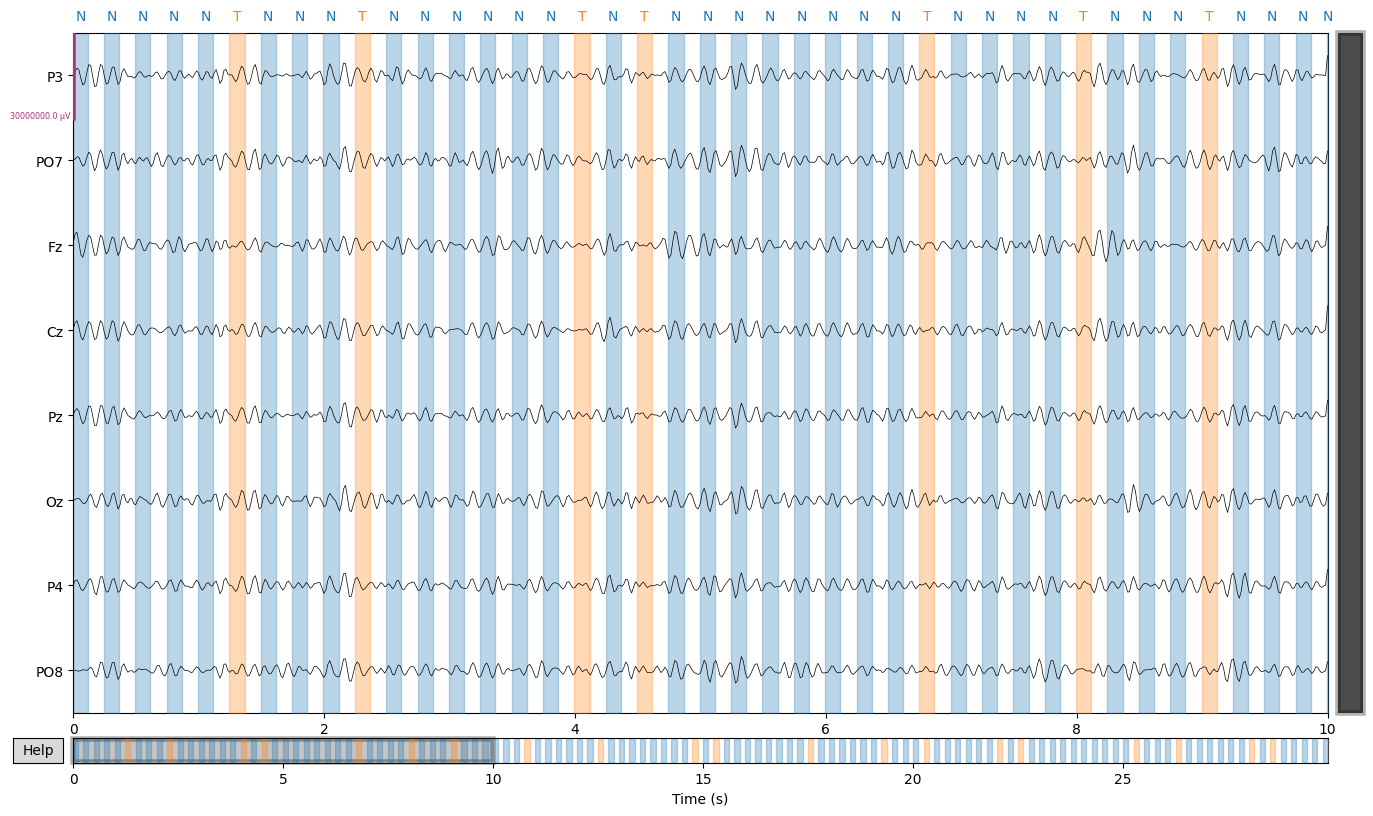

Patient 6


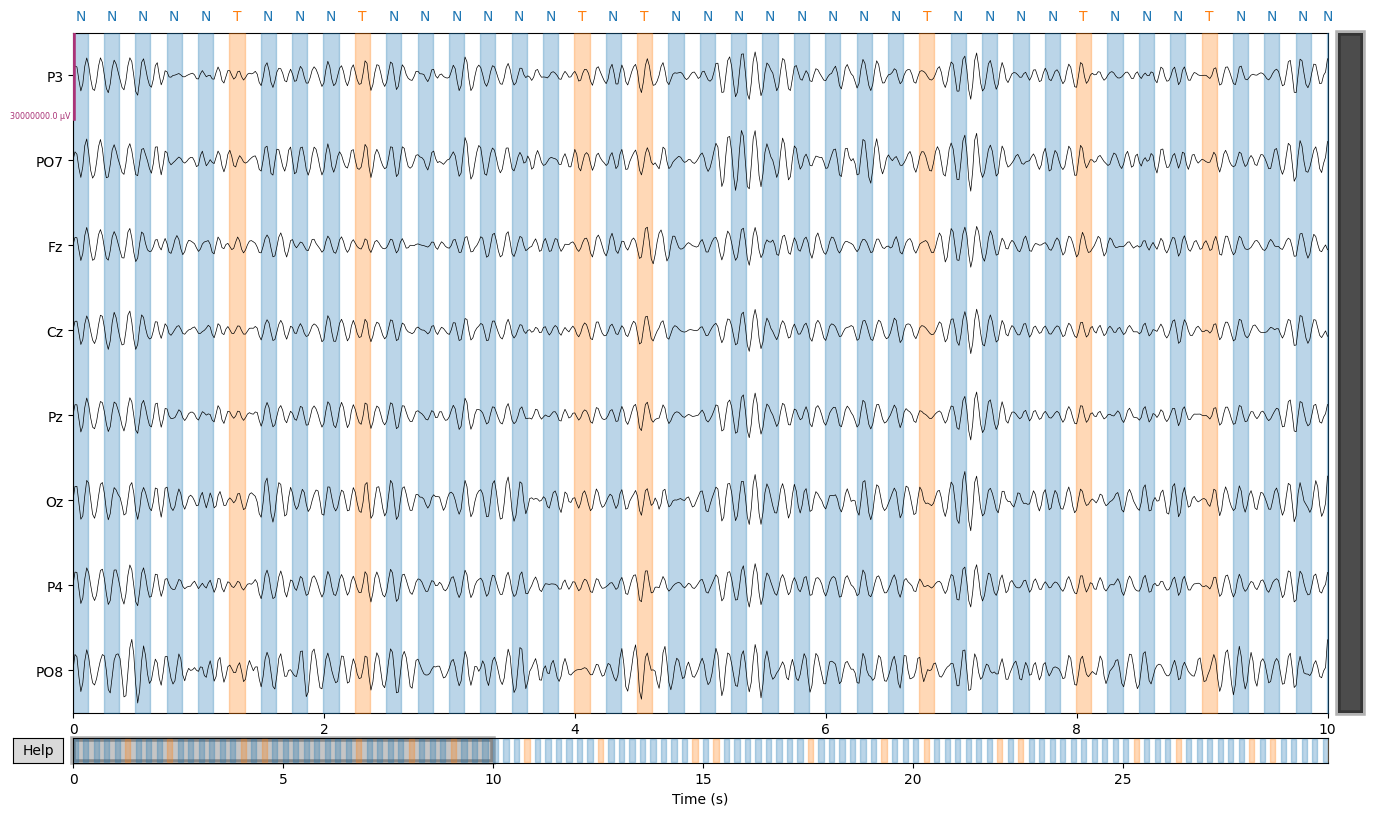

Patient 7


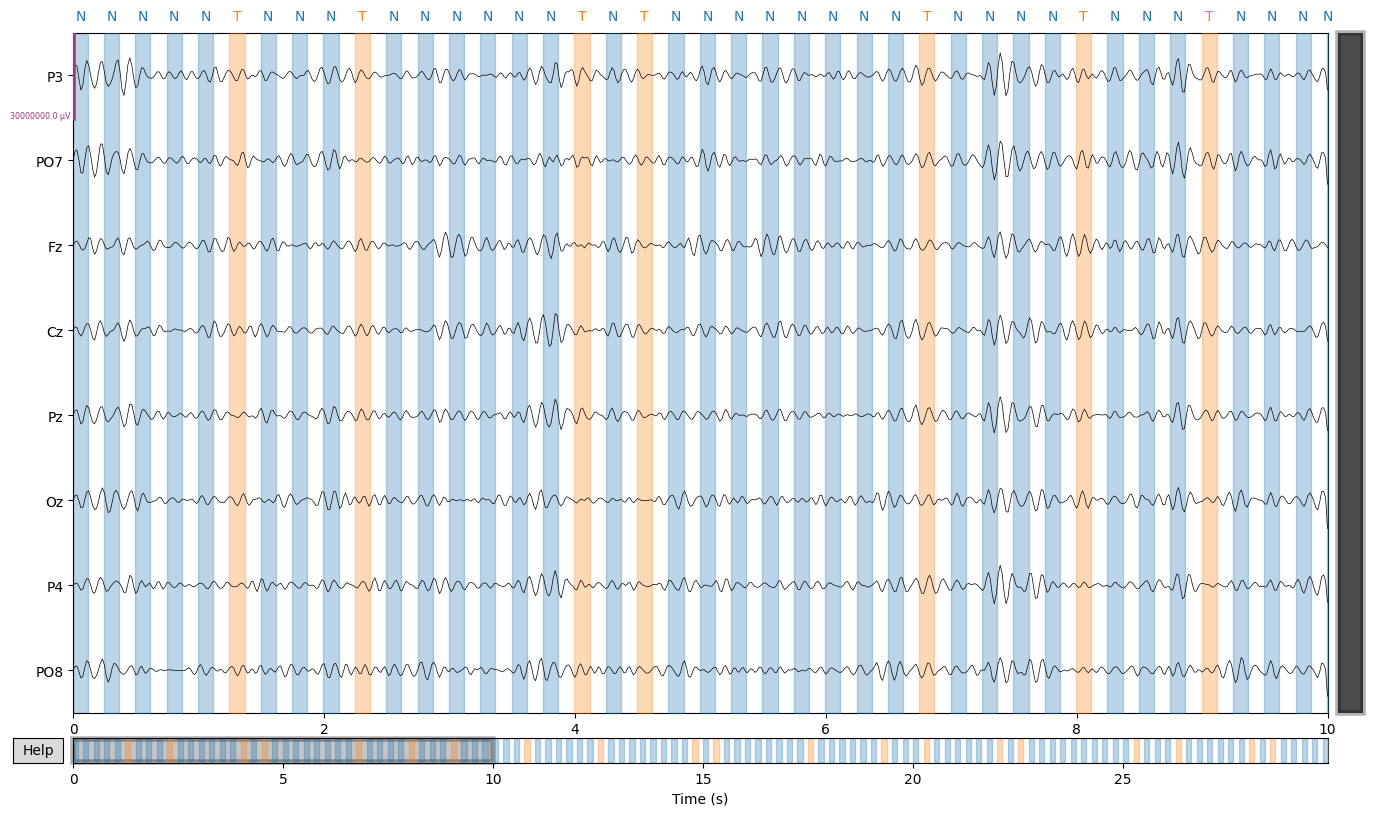

Patient 8


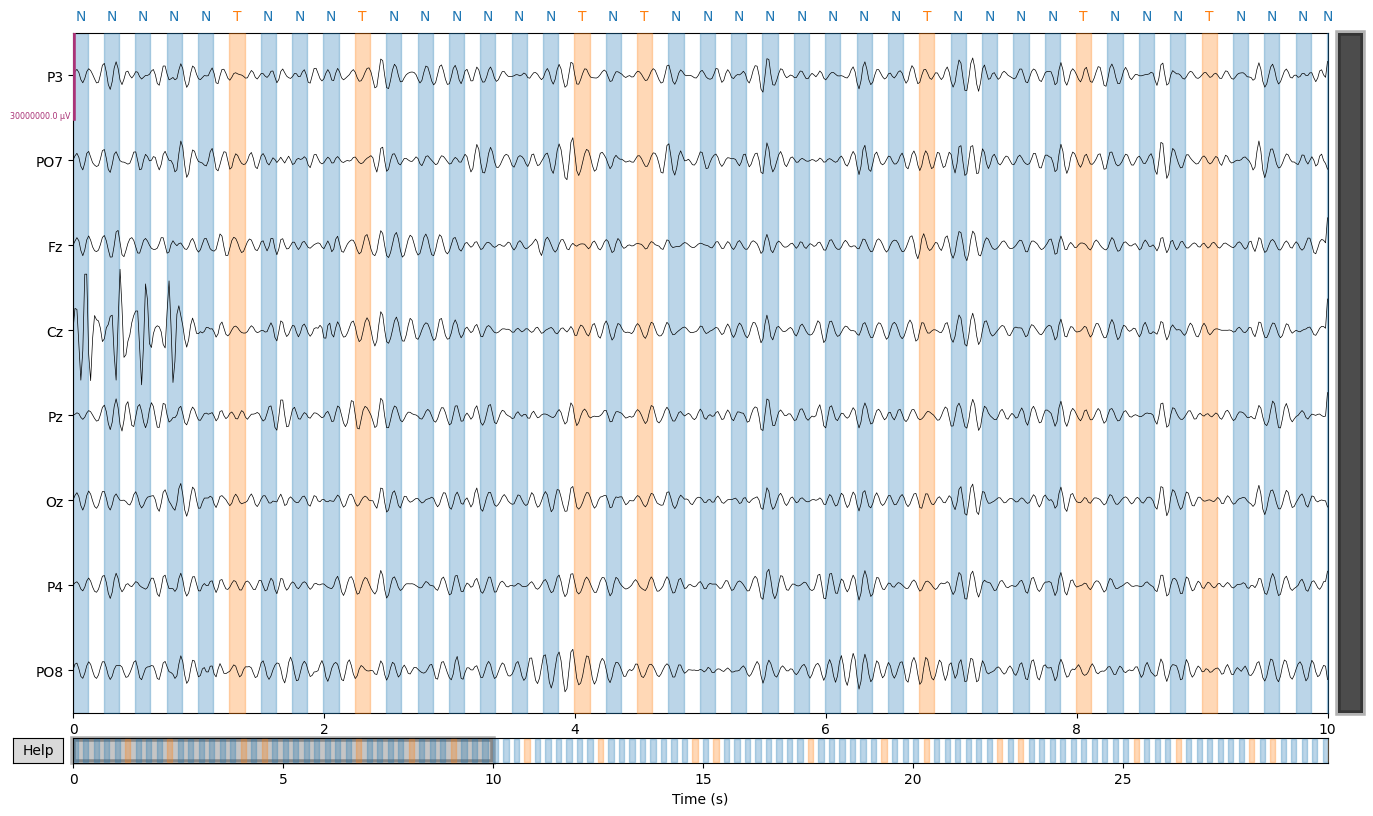

In [32]:
%matplotlib inline
for i in range(X.shape[0]):
    print(f"Patient {i+1}")
    view_signal(X_filtered[i, 0, 0, :, :], title=f'Patient {i+1}', lowpass=20, highpass=8, y=y_target[i], scalings=dict(eeg=15))

### Calculating average waveform of each onset



In the paper, the waveform that occured in each trial between 200-700 ms after each onset was collected from 'Cz' channel. The average waveform was calculated for each onset type (Target and Non-target). The highest value of the difference between the average target and non-target waveform was considered as the P300 amplitude.

(700, 204) (3496, 204)


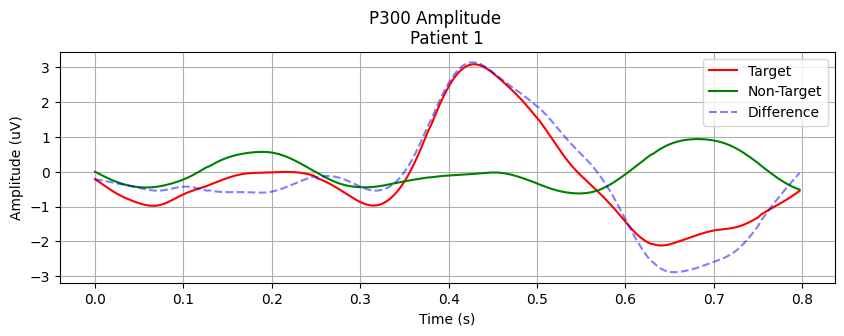

(700, 204) (3496, 204)


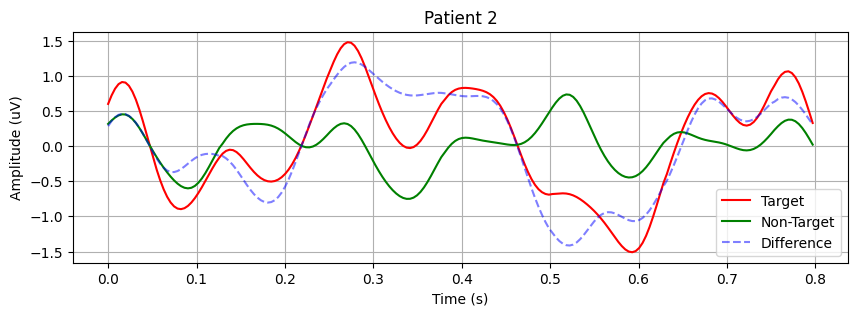

(700, 204) (3496, 204)


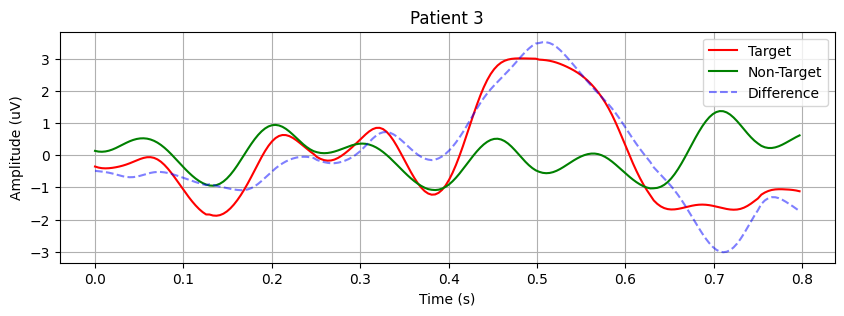

(700, 204) (3496, 204)


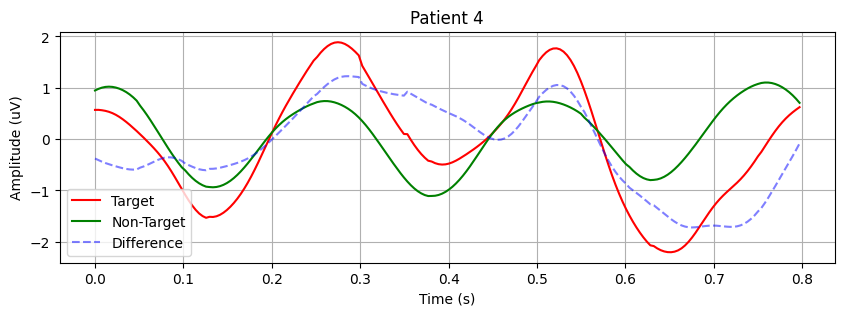

(700, 204) (3496, 204)


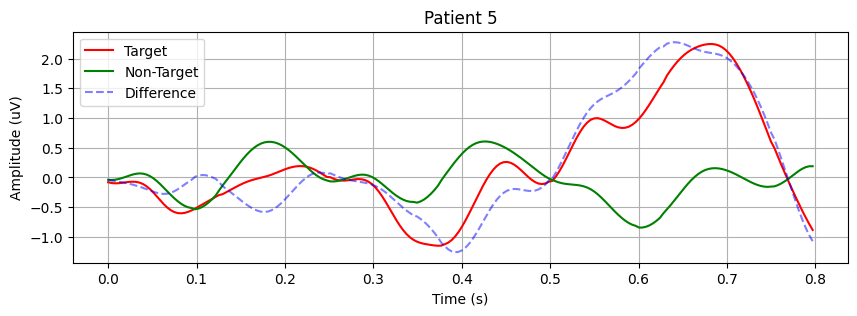

(700, 204) (3496, 204)


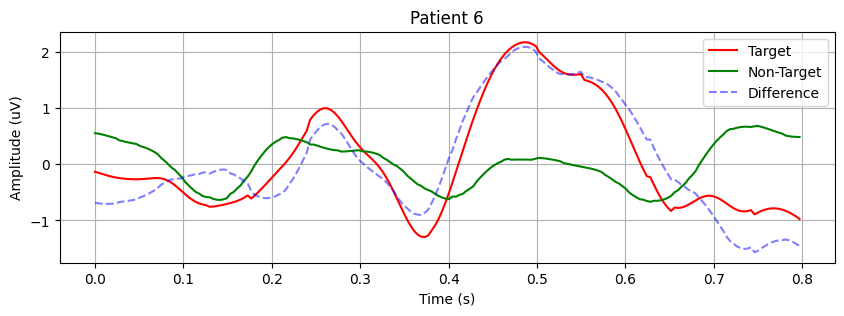

(700, 204) (3496, 204)


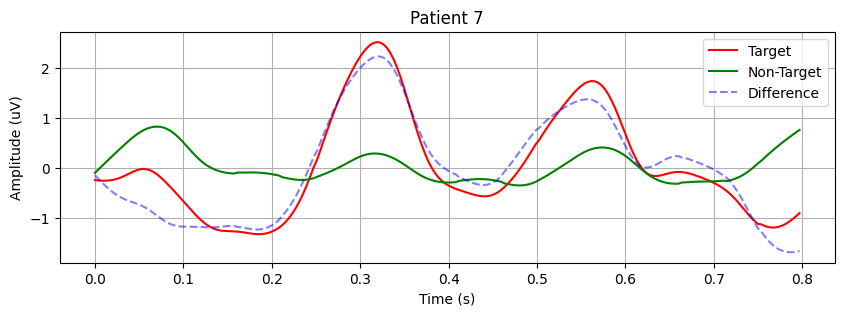

(700, 204) (3496, 204)


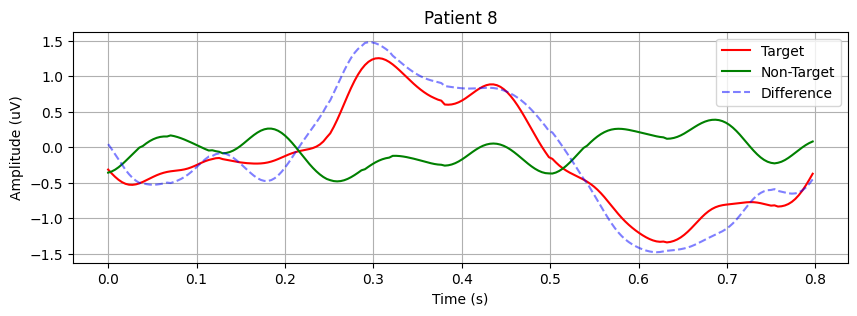

In [33]:
waveform_start_time_after_onset = 0
waveform_end_time_after_onset = 1000
waveform_start_sample_after_onset = int(sample_frequency * waveform_start_time_after_onset / 1000)
waveform_end_sample_after_onset = 17*12
#waveform_end_sample_after_onset = int(sample_frequency * waveform_end_time_after_onset / 1000)

for i in range(X_filtered.shape[0]):
    target_waveforms = []
    non_target_waveforms = []
    x = X_filtered[i, :, :, :, get_channel_index(patient_data[0], 'Cz')].reshape(-1)
    y = y_target[i].reshape(-1)
    
    for j in range(1, y.size):
        if (y[j] != 0) and  (y[j-1] != y[j]): # start of onset
            if j + waveform_end_sample_after_onset < y.size:
                if y[j] == 1:
                    non_target_waveforms.append(x[j+waveform_start_sample_after_onset:j+waveform_end_sample_after_onset])
                else:
                    target_waveforms.append(x[j+waveform_start_sample_after_onset:j+waveform_end_sample_after_onset])
    
    target_waveforms = np.array(target_waveforms)
    non_target_waveforms = np.array(non_target_waveforms)
    
    x_axis = np.linspace(0, target_waveforms.shape[1]/sample_frequency, target_waveforms.shape[1])
    print(target_waveforms.shape, non_target_waveforms.shape)
    target_waveforms = np.mean(target_waveforms, axis=0)
    non_target_waveforms = np.mean(non_target_waveforms, axis=0)
    
    
    plt.figure(figsize=(10,3))
    if i == 0:
        plt.suptitle("P300 Amplitude", y=1.02)
    plt.title(f"Patient {i+1}")
    
    plt.plot(x_axis, target_waveforms, 'r-', label='Target')
    plt.plot(x_axis, non_target_waveforms, 'g-', label='Non-Target')
    plt.plot(x_axis, target_waveforms - non_target_waveforms, 'b--', alpha=0.5, label='Difference')
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.legend()
    plt.grid()
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    

## Classification - Part 1



**Extract from the paper (Single trial classification)**



To provide an estimate of the classifier accuracy we considered the binary classification problem target vs. non-target (Blankertz et al., 2011) that takes into account the correct classification of a target or of a non-target. Frequency filtering, data segmentation and artifact rejection were conducted as in P300 morphology section. EEG data were then resampled by replacing each sequence of 12 samples with their mean value, yielding 17 × 8 samples per epoch (eight being the number of channels), which were concatenated in a feature vector (Krusienski et al., 2006). A seven-fold cross-validation was used to evaluate the binary accuracy (BA) of the classifier on each participant’s dataset. For each iteration we applied a SWLDA on the testing dataset (consisting of six words) to extract the 60 most significant control features (Draper and Smith, 1998) and we assessed the BA on the training dataset (the remaining word).

In [34]:
def create_dataset(x, y, show_progress=False, get_delayed_samples=0, get_fft=False):
    """
    Input Shape: x: (Patients,Trial, Run, Samples, channels), y: (Patients,Trial, Run, Samples)
    Output Shape: (Data, Samples, channels), (Data, Samples)
    """
    waveform_start_time_after_onset = 0
    waveform_start_sample_after_onset = int(sample_frequency * waveform_start_time_after_onset / 1000)
    
    stimulus_samples = 256*stimulus_duration//1000
    waveform_end_sample_after_onset = stimulus_samples + get_delayed_samples
    
    x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4]))
    y = y.reshape((y.shape[0], y.shape[1] * y.shape[2] * y.shape[3]))
    
    x_result = []
    y_result = []
    
    for patient in range(x.shape[0]):
        val = range(x.shape[1])
        if show_progress:
            val = tqdm(val)
        for sample in val:
            if (y[patient, sample] != 0) and  (y[patient, sample-1] != y[patient, sample]): # start of onset
                if sample + waveform_end_sample_after_onset < y.shape[-1]:
                    x_result.append(x[patient, sample+waveform_start_sample_after_onset:sample+waveform_end_sample_after_onset, :])
                    y_result.append(y[patient, sample])
    
    return np.array(x_result), np.array(y_result)

In [35]:
# As per paper number of samples are 17*12 which and then a running average of 12 samples is calculated to obtain 17 samples
samples = 17*12
additional_samples = samples - (256*stimulus_duration//1000)
x, y = create_dataset(X_filtered, y_target, True, additional_samples)
x.shape

100%|██████████| 267680/267680 [00:00<00:00, 571489.59it/s]


(33576, 204, 8)

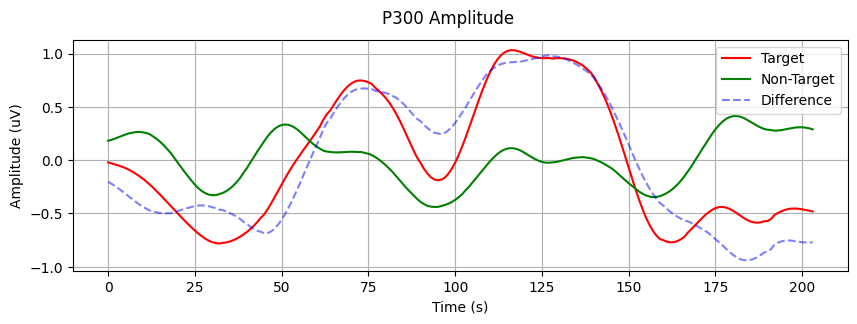

In [36]:
target_waveforms = np.mean(x[np.where(y == 2)[0], :, get_channel_index(patient_data[0], 'Cz')], axis=0)

non_target_waveforms = np.mean(x[np.where(y == 1)[0], :, get_channel_index(patient_data[0], 'Cz')], axis=0)

plt.figure(figsize=(10,3))

plt.suptitle("P300 Amplitude")
plt.plot(target_waveforms, 'r-', label='Target')
plt.plot(non_target_waveforms, 'g-', label='Non-Target')
plt.plot(target_waveforms - non_target_waveforms, 'b--', alpha=0.5, label='Difference')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.legend()
plt.grid()
plt.subplots_adjust(hspace=0.5)
plt.show()

(17,)


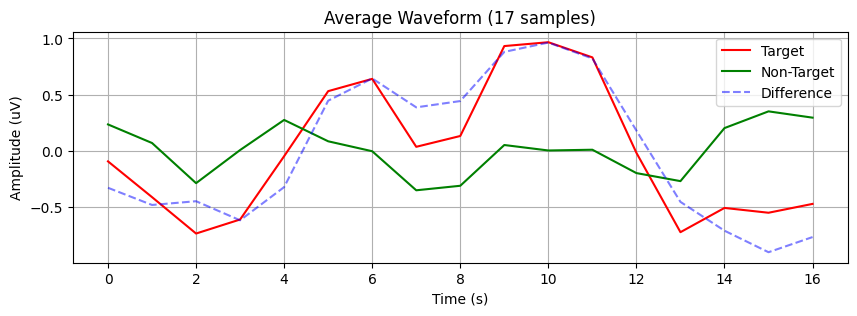

In [37]:
target_waveforms = np.reshape(target_waveforms, (17, 12)).mean(axis=1)
print(target_waveforms.shape)
non_target_waveforms = np.reshape(non_target_waveforms, (17, 12)).mean(axis=1)

plt.figure(figsize=(10, 3))
plt.title("Average Waveform (17 samples)")
plt.plot(target_waveforms, 'r-', label='Target')
plt.plot(non_target_waveforms, 'g-', label='Non-Target')
plt.plot(target_waveforms - non_target_waveforms, 'b--', alpha=0.5, label='Difference')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.legend()
plt.grid()
plt.subplots_adjust(hspace=0.5)
plt.show()

### Create Dataset:



1. Labels: Non-Target(1), Target (2)

2. Input Size: 17x8 = 136

In [38]:
total_samples_per_class = 17*12 # Number of samples in each waveform
additional_samples = total_samples_per_class - int(256*stimulus_duration/1000) # Additional sample
x, y = create_dataset(X_filtered, y_target, get_delayed_samples=additional_samples, show_progress=True)
y = y - 1
print(x.shape)

# Bring channel to second axis for ease of visualization
x = x.transpose((0, 2, 1))

# Calculate average of consecutive 12 samples to get a sample of size 17x8
x = x.reshape((x.shape[0], x.shape[1], 17, 12)).mean(axis=-1)
x, y = shuffle(x, y, random_state=12432)
X_data = x.copy()
y_data = y.copy()
x = x.reshape((x.shape[0], -1))
print(x.shape)

100%|██████████| 267680/267680 [00:00<00:00, 573177.69it/s]


(33576, 204, 8)
(33576, 136)


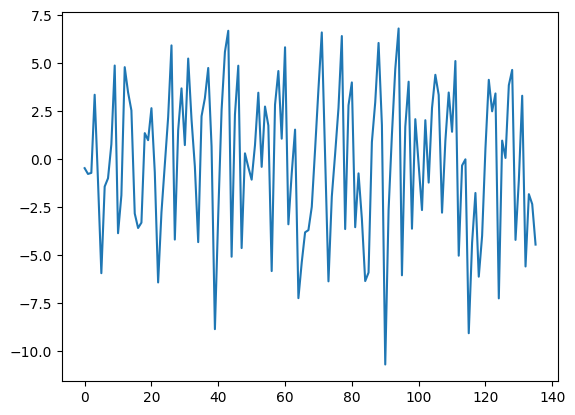

In [39]:
plt.figure()
plt.plot(x[2, :])
plt.show()

In [40]:
np.unique(y)

array([0, 1], dtype=uint8)

In [41]:
# Balancing the dataset

data_per_class = 5600

indices = np.concatenate((np.where(y == 0)[0][:data_per_class], np.where(y == 1)[0][:data_per_class]))

x = x[indices, :]

y = y[indices]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6150)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8960, 136) (8960,) (2240, 136) (2240,)


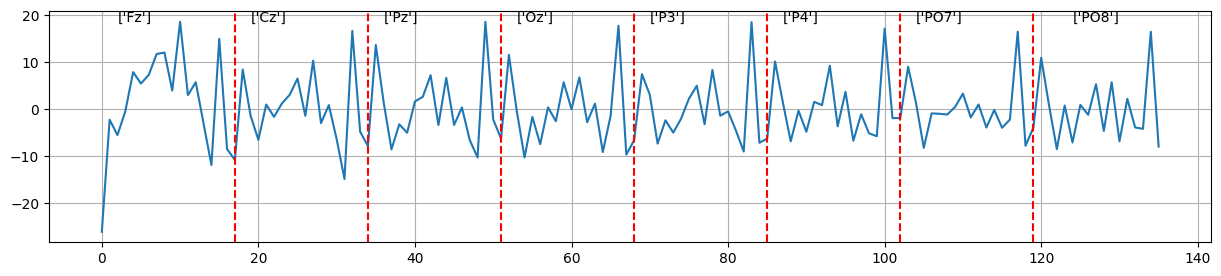

In [43]:
plt.figure(figsize=(15, 3))
plt.plot(x[0, :])
a = np.max(x[0])
for i in range(1, 8):
    p = x.shape[-1]//8*i
    plt.axvline(x=p, color='red', linestyle='--')
    plt.text(p-15, a, get_channel_name(patient_data[0], i-1))
    if i == 7:
        plt.text(p+5, a, get_channel_name(patient_data[0], i))
plt.grid()
plt.show()

### PCA for visualization

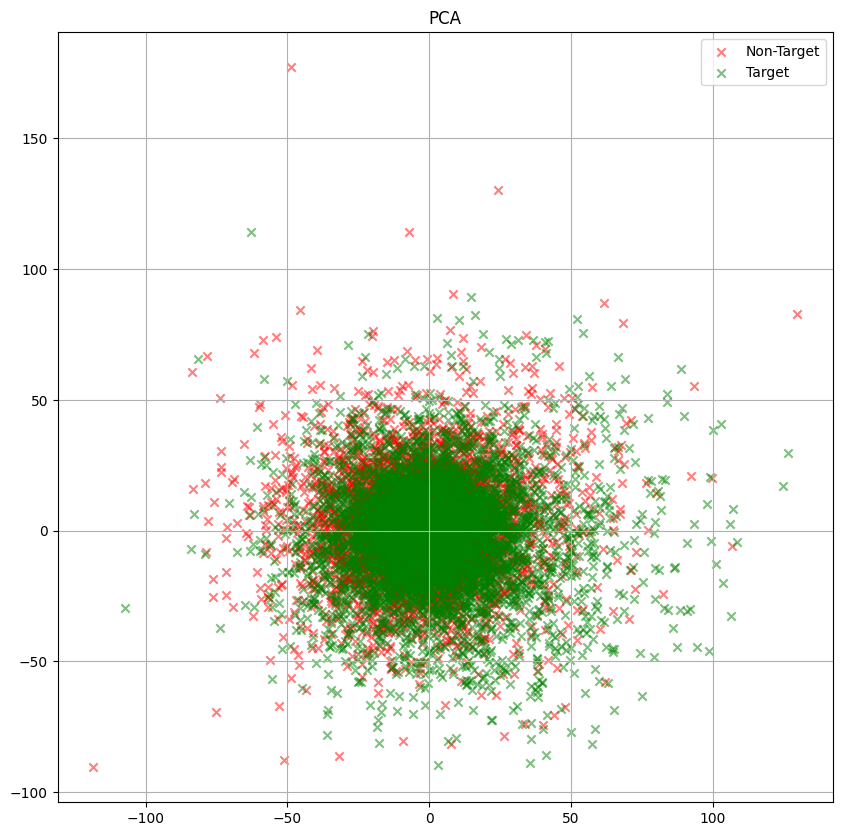

In [44]:
a = PCA(n_components=2).fit(x).transform(x)

plt.figure(figsize=(10, 10))
plt.title("PCA")
plt.scatter(a[y == 0, 0], a[y == 0, 1], label='Non-Target', color='r', alpha=0.5, marker='x')
plt.scatter(a[y == 1, 0], a[y == 1, 1], label='Target', color='g', alpha=0.5, marker='x')
plt.grid()
plt.legend()
plt.show()

## Stepwise LDA



Source: https://sebastianraschka.com/Articles/2014_python_lda.html



LDA is a supervised machine learning algorithm that reduces the number of dimensions in feature space of a dataset. However, the number of reduced dimension is equal to the minimum value between the number of features in the feature space minus one and total number of classes minus one. Since, this classification algorithm consists of just 2 classes(Target and Non-Target) the reduced number of feature is equal to 1.



Therefore, in order to extract multiple important features using LDA we need to compute Stepwise Linear Discriminant Analysis(SWLDA) which is a form of LDA but calculates multiple important features in order to reduce the dimensionality of the feature space.





### Overview



__Summarizing the LDA approach in 5 steps:__





Listed below are the 5 general steps for performing a linear discriminant analysis; we will explore them in more detail in the following sections.





1. Compute the d-dimensional mean vectors for the different classes from the dataset.





2. Compute the scatter matrices (in-between-class and within-class scatter matrix).





3. Compute the eigenvectors (e_1,e_2,...,e_d) and corresponding eigenvalues (λ_1,λ_2,...,λ_d) for the scatter matrices.





4. Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d×k dimensional matrix W (where every column represents an eigenvector).





5. Use this d×k eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication: Y=X×W (where X is a n×d-dimensional matrix representing the n samples, and y are the transformed n×k-dimensional samples in the new subspace).


### Compute the d-dimensional mean vectors for the different classes from the dataset.



Calculate Mean of feature vector for all signals of each class.



__Shape of Mean Vector:__ MxN where M is no. of classes and N is No. of features





### 2. Compute the Scatter Matrices



Now, we will compute the two 4x4-dimensional matrices: The within-class and the between-class scatter matrix.



__a. Within Class Scatter Matrix, $S_W$:__



The within-class scatter matrix SW is computed by the following equation:





$$ S_W=\sum_{i=1}^c S_i $$

where 'c' i the no. of available classes and




$$ S_i=\sum_{x∈D_i}^n (x−m_i)(x−m_i)^T $$

Here,
__x__ = A feature vector that belongs to the $i^{th}$ class
$D_i$ = The set of feature vectors(signals) in the $i^{th}$ class
__n__ = Total no. of feature vectors/signals in the $i^{th}$ class
$m_i$ = Mean vector for the $i^{th}$ class



$$ m_i = \frac{1}{n_i} \sum_{x∈D_i}^n x_k $$

Here, $x_k$ = $k^{th}$ feature vector/signal belonging to the $i^{th}$ class
__b. Between class Scatter matrix, $S_B$:__
The between-class scatter matrix SB is computed by the following equation:



$$ S_B = \sum_{i=1}^c N_i (m_i - m) (m_i - m)^T $$



Here,

__c__ = Number of Total Classes available
$N_i$ = Size(Total feature vectors/signals) in $i^{th}$ class
$m_i$ = Mean vector of the $i^{th}$ class
$m$ = Overall Mean(For all classes)

### 3. Solving the generalized eigenvalue problem for the matrix $S^{−1}_W S_B$
1. Next, we will solve the generalized eigenvalue problem for the matrix $S^{−1}_W S_B$ to obtain the linear discriminants.
2. Then we will perform a quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:
$$Av=\lambda v $$

Here,
$A$ = $S^{−1}_W S_B$
$v$ = Eigenvector
$\lambda$ = eigenvalue

### 4. Selecting linear discriminants for the new feature subspace
#### 4.1 Sorting the eigenvectors by decreasing eigenvalues
Remember from the introduction that we are not only interested in merely projecting the data into a subspace that improves the class separability, but also reduces the dimensionality of our feature space, (where the eigenvectors will form the axes of this new feature subspace).

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.

The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top k eigenvectors.

#### 4.2 Choosing k eigenvectors with the largest eigenvalues
After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our k×d-dimensional eigenvector matrix W (here N×2: based on the 2 most informative eigenpairs) and thereby reducing the initial N-dimensional feature space into a 2-dimensional feature subspace.

### 5. Transforming the samples onto the new subspace
In the last step, we use the 4×2-dimensional matrix WW that we just computed to transform our samples onto the new subspace via the equation:



$$ Y = X x W $$
(where X is a n×d-dimensional matrix representing the n samples, and Y are the transformed n×k-dimensional samples in the new subspace).

In [45]:
class StepwiseLDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.classes = []
        self.eigenpairs = []
        self.weights = None
        
    def transform(self, x):
        if self.weights is None:
            raise ValueError("Please fit the model before using it")
            
        return x.dot(self.weights)
        
    def fit(self, x, y):
        self.classes = np.unique(y)
        
        # Calculate mean vectors
        mean_vectors = []
        for c in self.classes:
            mean_vectors.append(np.mean(x[y == c], axis=0))
        mean_vectors = np.array(mean_vectors)
        
        
        
        s_w = np.zeros((x.shape[1],x.shape[1]))  # Create scatter within matrix for each feature
        s_b = np.zeros((x.shape[1],x.shape[1]))  # Between Class Scatter Matrix
        overall_mean = np.mean(x, axis=0).reshape(x.shape[1],1)  # Mean for all classes
        
        for cl, mv in zip(self.classes, mean_vectors):  # For each class and its corresponding mean vector
            mv = mv.reshape(x.shape[1],1) # transpose mean vector of the current class
            x_target = x[y==cl]  # Calculate size/total no. of feature vectors in the current class
            n = x_target.shape[0]
            
            # Calculate within-class Scatter matrix
            class_sc_mat = np.zeros((x.shape[1],x.shape[1]))                  # scatter matrix for every class
            for row in x_target:
                row = row.reshape(x.shape[1],1) # make column vectors
                class_sc_mat += (row-mv).dot((row-mv).T)
            
            s_w += class_sc_mat                             # sum class scatter matrices
            
            # calculate between-class scatter matrix            
            s_b += n * (mv - overall_mean).dot((mv - overall_mean).T)  # Calculate Between class scatter matrix
            
        # Compute Eigen Value and Eigenvector for the dot product between the two matrices
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(s_w).dot(s_b))
        
        
        # Make a list of (eigenvalue, eigenvector) tuples
        self.eigenpairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        self.eigenpairs = sorted(self.eigenpairs, key=lambda k: k[0], reverse=True)
        
        # Calculate weights
        self.weights = self.eigenpairs[0][1].reshape(x.shape[1],1)
        #W = np.hstack((, eig_pairs[1][1].reshape(x_tr_an.shape[1],1)))
        for i in range(1, self.n_components):
            self.weights = np.hstack((self.weights, self.eigenpairs[i][1].reshape(x.shape[1],1)))
            
        return self

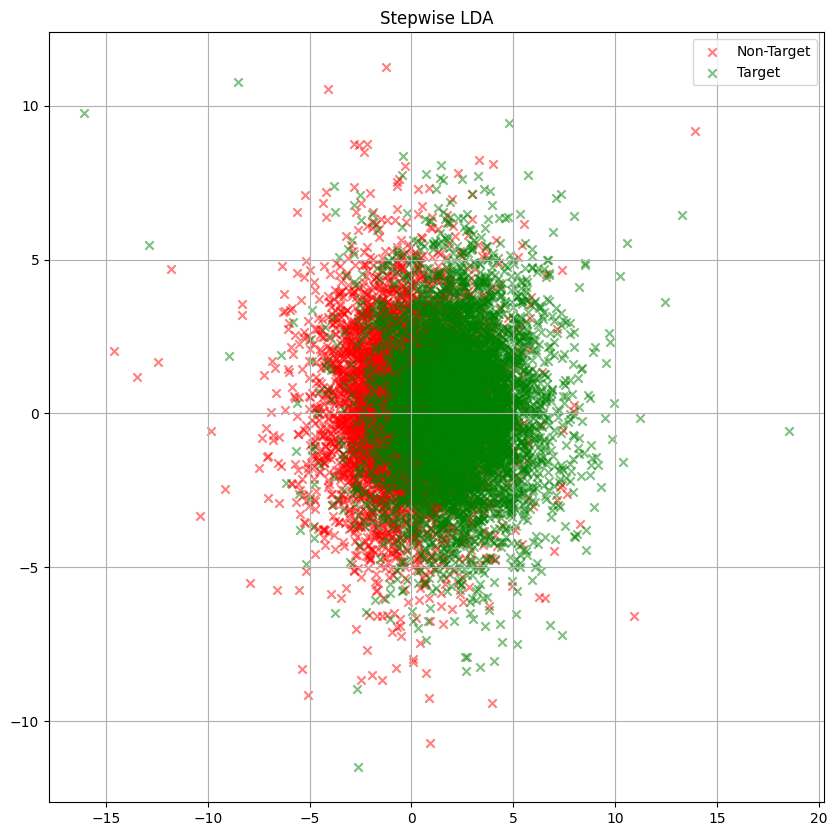

In [46]:
a =  StepwiseLDA(n_components=2).fit(x, y).transform(x)
plt.figure(figsize=(10, 10))
plt.title("Stepwise LDA")
plt.scatter(a[y == 0, 0].real, a[y == 0, 1].real, label='Non-Target', color='r', alpha=0.5, marker='x')
plt.scatter(a[y == 1, 0].real, a[y == 1, 1].real, label='Target', color='g', alpha=0.5, marker='x')
plt.grid()
plt.legend()
plt.show()

## Random Forest Classification



We will perform Random Forest Classification using the following datasets:



1. **Simple waveform:** Here we will use the individual waveforms as the input data.



2. **PCA Feature:** Here, we will use PCA on each individual waveform to extract important features and perform classification on those feature as inputs.



2. **Stepwise LDA Feature:** Here, we will use Step-Wise LDA on each individual waveform to extract important features and perform classification on those feature as inputs.


### 1. Simple Waveform

In [47]:
clf = RandomForestClassifier(max_depth=2, random_state=26784)

clf.fit(X_train, y_train)

print(f"Accuracy: {clf.score(X_test, y_test)*100:.5f}%")

Accuracy: 61.29464%


### 2. PCA

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


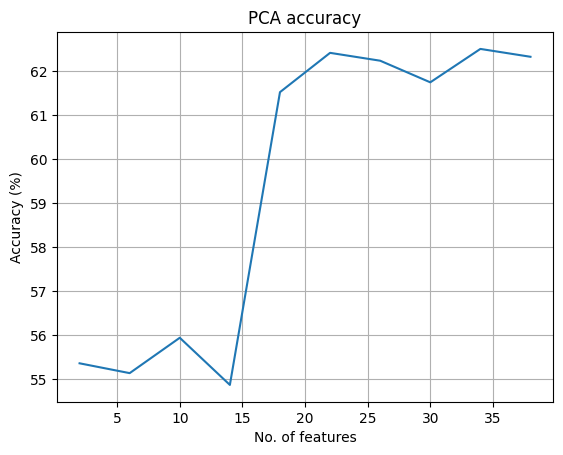

In [48]:
input_features = np.arange(2, 42, 4)
accuracies = []

for f in tqdm(input_features):
    pca = PCA(n_components=f)
    pca.fit(X_train, y_train)
    a, b = pca.transform(X_train), pca.transform(X_test)
    clf = RandomForestClassifier(max_depth=2, random_state=26784)
    clf.fit(a, y_train)
    accuracies.append(clf.score(b, y_test)*100)

    
plt.figure()
plt.title("PCA accuracy")
plt.plot(input_features, accuracies)
plt.grid()
plt.xlabel("No. of features")
plt.ylabel("Accuracy (%)")
plt.show()

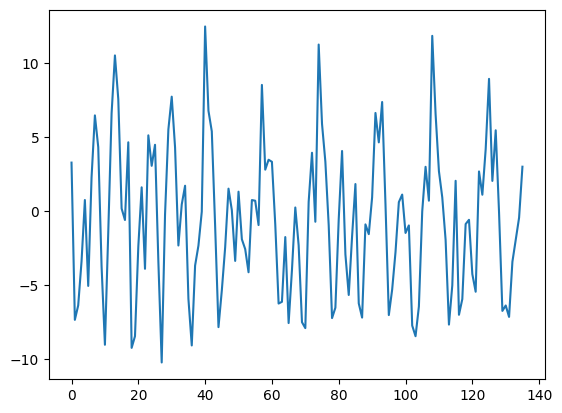

In [49]:
plt.figure()

plt.plot(X_train[9, :])

plt.show()

In [50]:
X_train.shape

(8960, 136)

### 3. Stepwise LDA

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


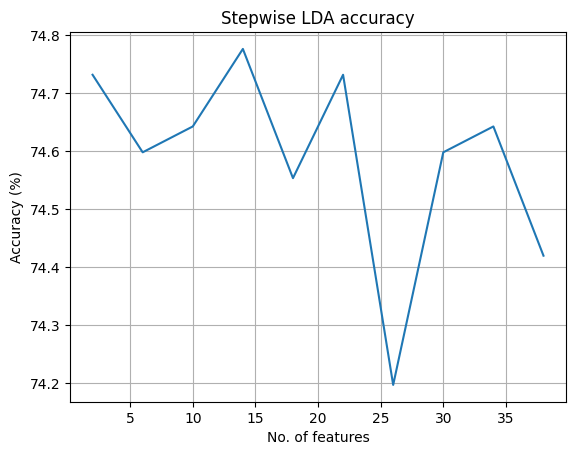

In [51]:
input_features = np.arange(2, 42, 4)
accuracies = []

for f in tqdm(input_features):
    lda = StepwiseLDA(f)
    lda.fit(X_train, y_train)
    a, b = lda.transform(X_train), lda.transform(X_test)
    clf = RandomForestClassifier(max_depth=2, random_state=26784)
    clf.fit(a.real, y_train)
    accuracies.append(clf.score(b.real, y_test)*100)

    
plt.figure()
plt.title("Stepwise LDA accuracy")
plt.plot(input_features, accuracies)
plt.grid()
plt.xlabel("No. of features")
plt.ylabel("Accuracy (%)")
plt.show()

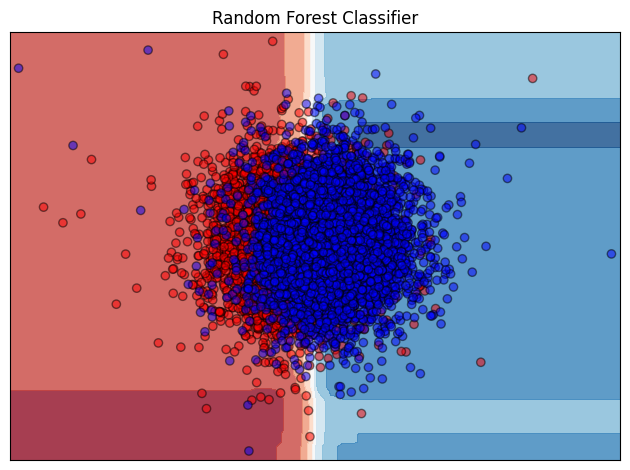

In [52]:
a =  StepwiseLDA(n_components=2).fit(x, y).transform(x)
clf = RandomForestClassifier(max_depth=2, random_state=26784)
clf.fit(a.real, y)
    
plt.figure()

ax = plt.subplot(1, 1, 1)
ax.set_title("Random Forest Classifier")

DecisionBoundaryDisplay.from_estimator(
            clf, a.real, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5
        )

ax.scatter(a[:, 0].real, a[:, 1].real, c=y, alpha=0.5, edgecolors="k", cmap=ListedColormap(["#FF0000", "#0000FF"]))

x_min, x_max = a[:, 0].real.min() - 0.5, a[:, 0].real.max() + 0.5
y_min, y_max = a[:, 1].real.min() - 0.5, a[:, 1].real.max() + 0.5
    
ax.set_xlim(x_min, x_max)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())


plt.tight_layout()
plt.show()

Stepwise LDA provides the best classification accuracy when the number of features is around 35-40. However, the classification accuracy is around 90\%.



## Distribution of the data

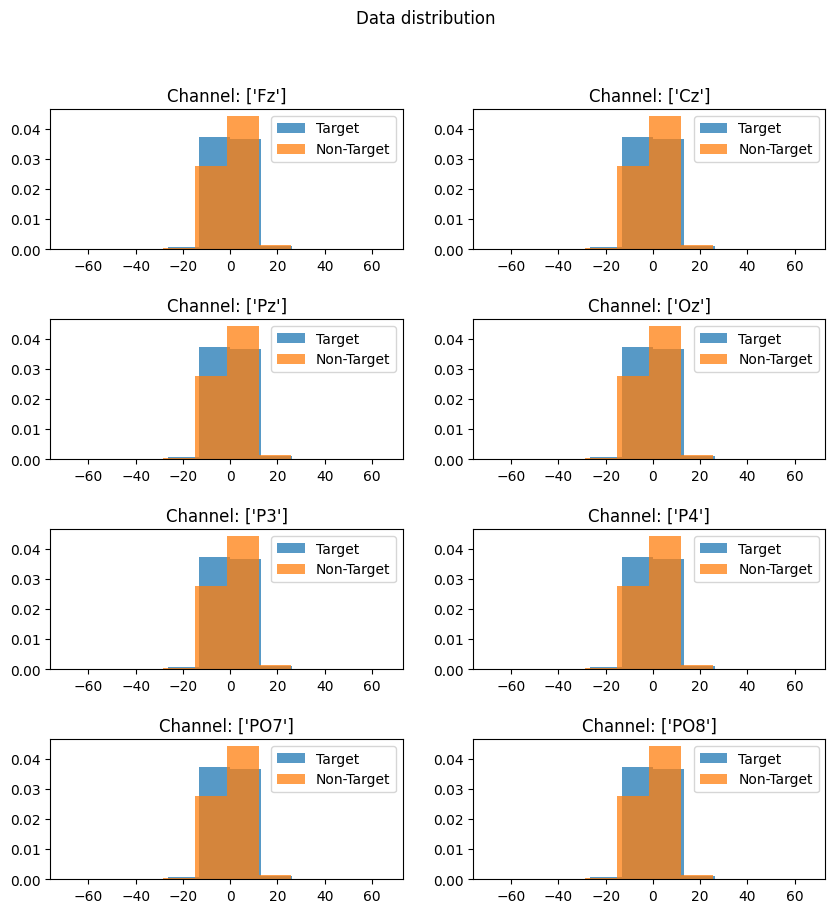

In [53]:
cols = 2
rows = X_data.shape[1]/cols
if int(rows) != rows:
    rows = int(rows) + 1
else:
    rows = int(rows)




current = 0

fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
plt.suptitle("Data distribution")
for j in range(rows):
    for k in range(cols):
        if current >= X_data.shape[1]:
            break
        ax[j, k].set_title(f"Channel: {get_channel_name(patient_data[0], current)}")
        
        
        ax[j, k].hist(X_data[y_data == 1].reshape(-1)+1e-6, density=True, label='Target', alpha=0.75)
        ax[j, k].hist(X_data[y_data == 0].reshape(-1)+1e-6, density=True, label='Non-Target', alpha=0.75)       
        ax[j, k].legend()
        
        current += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

### Statistical significance of P300



P300 should have a positive deflection in the waveform generated between 200-700 ms after the onset of a stimulus. As seen from the average waveforms calculated above (P300 Amplitude) we do see that the target signal of each channel has a positive peak compared to non-target signal. We would like to check the significance level of this statement.  



To calculate whether target waveforms have higher amplitude, we will first calculate the average waveform from a number of sample signals. We will then calculate the average positive peak amplitude of the average waveform. This will provide us the highest peak amplitude of the waveform. We will then test on average, whether the peak amplitude of a target waveform is higher than a non-target waveform.



Therefore, we would like to test the following - Target waveforms have a lower or equal peak amplitude than non-target waveforms. i.e.



$$ H_0 : \mu_{target} - \mu_{nontarget} \leq 0$$ 
$$H_1 : \mu_{target} - \mu_{nontarget} > 0$$


In [54]:
x_target = X_data[np.where(y_data == 1)[0]]

x_nontarget = X_data[np.where(y_data == 0)[0]]

print(x_target.shape)

(5600, 8, 17)


Target Mean: 0.4057008735905658, Std: 0.09296062528540285
Non-Target Mean: 0.28041282483497276, Std: 0.08970705540355005
Confidence interval: ConfidenceInterval(low=0.09464195777259235, high=inf), T-Score: 6.788786, Degree of freedom: 97.87587564983389, P-Value: 4.3867397035726996e-10
With a significance level of 0.05000, the hypothesis is rejected


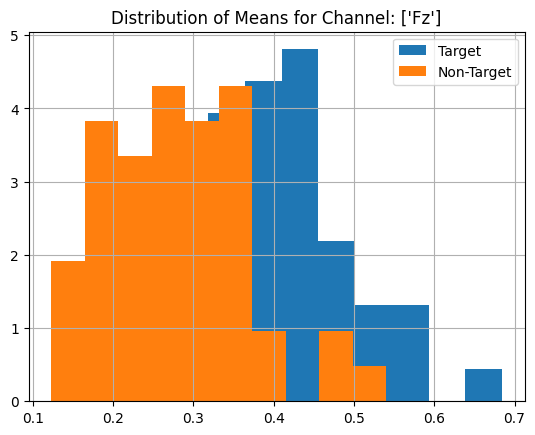

Target Mean: 0.32760317848364423, Std: 0.09168312198738764
Non-Target Mean: 0.23842941248518304, Std: 0.07316619028578474
Confidence interval: ConfidenceInterval(low=0.06133480140803246, high=inf), T-Score: 5.321577, Degree of freedom: 93.40280363577722, P-Value: 3.5172843051044583e-07
With a significance level of 0.05000, the hypothesis is rejected


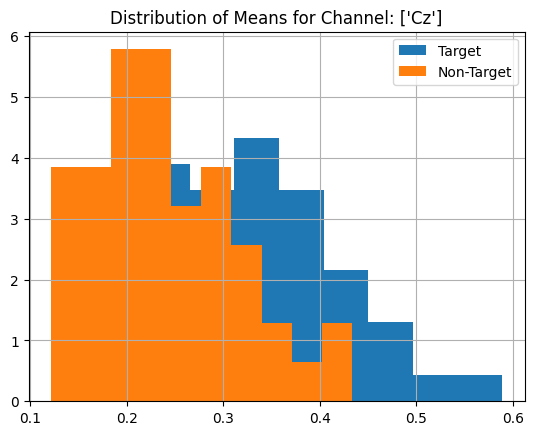

Target Mean: 0.25528328549944646, Std: 0.052557360727234374
Non-Target Mean: 0.22590618982649943, Std: 0.057325275427701966
Confidence interval: ConfidenceInterval(low=0.010926607525021306, high=inf), T-Score: 2.644140, Degree of freedom: 97.27019844188179, P-Value: 0.004774311442633485
With a significance level of 0.05000, the hypothesis is rejected


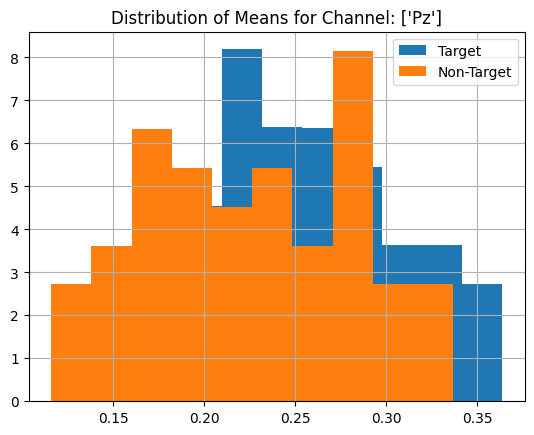

Target Mean: 0.2818093778859499, Std: 0.05829835687787511
Non-Target Mean: 0.21411258429920424, Std: 0.048833426167419536
Confidence interval: ConfidenceInterval(low=0.04965110949440345, high=inf), T-Score: 6.231240, Degree of freedom: 95.07731701272859, P-Value: 6.297373496514045e-09
With a significance level of 0.05000, the hypothesis is rejected


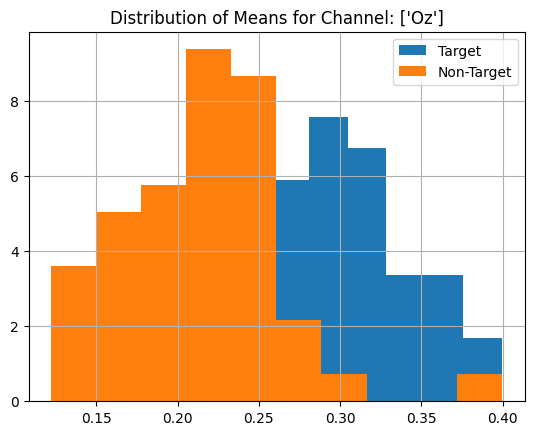

Target Mean: 0.2880191731176912, Std: 0.06891029417145683
Non-Target Mean: 0.2182054821195298, Std: 0.05378594079084384
Confidence interval: ConfidenceInterval(low=0.04906505117717873, high=inf), T-Score: 5.590462, Degree of freedom: 92.5425002400378, P-Value: 1.1369286308778199e-07
With a significance level of 0.05000, the hypothesis is rejected


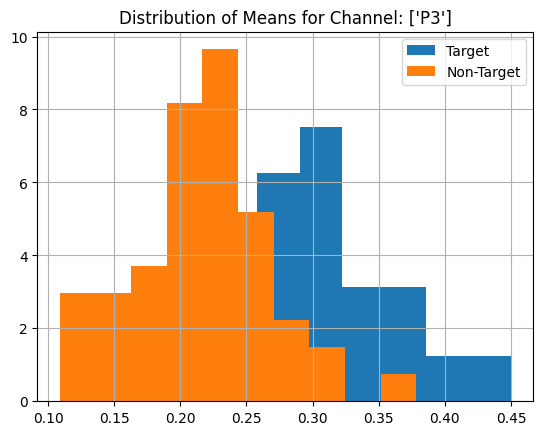

Target Mean: 0.2932284228295716, Std: 0.055755540712561884
Non-Target Mean: 0.22004992264516587, Std: 0.056365276458400906
Confidence interval: ConfidenceInterval(low=0.05437094244041265, high=inf), T-Score: 6.461061, Degree of freedom: 97.98840902913122, P-Value: 2.0210996659902957e-09
With a significance level of 0.05000, the hypothesis is rejected


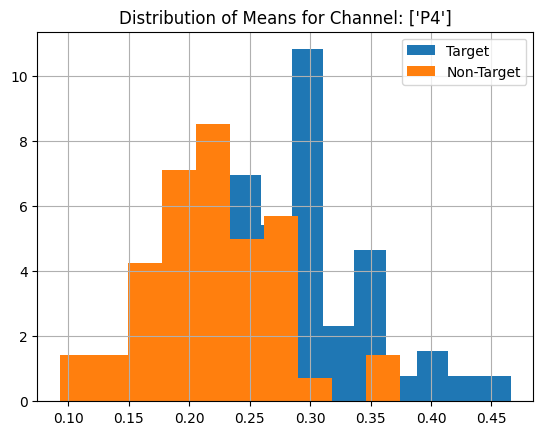

Target Mean: 0.3722725741209463, Std: 0.0740647218321472
Non-Target Mean: 0.2447286598519907, Std: 0.04936052277199278
Confidence interval: ConfidenceInterval(low=0.10639990690003731, high=inf), T-Score: 10.030883, Degree of freedom: 85.35537640547699, P-Value: 2.1319836435791482e-16
With a significance level of 0.05000, the hypothesis is rejected


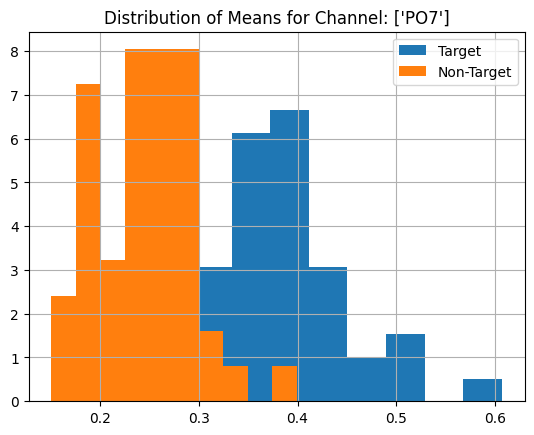

Target Mean: 0.36572129324849323, Std: 0.05216503321357481
Non-Target Mean: 0.21546229050644336, Std: 0.0448377833919234
Confidence interval: ConfidenceInterval(low=0.1339377840112083, high=inf), T-Score: 15.290924, Degree of freedom: 95.83744747172312, P-Value: 9.387788984262198e-28
With a significance level of 0.05000, the hypothesis is rejected


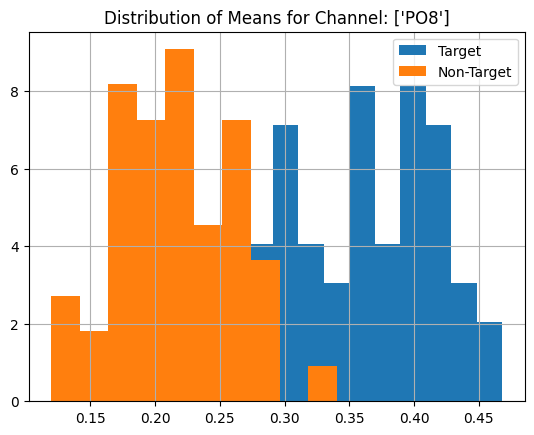

In [55]:
mean_calculation_data_size = 100
sample_size = 50



np.random.seed(34324)

def view_distribution():
    for channel in range(x_target.shape[1]):
        ma_t = []
        ma_nt = []
        for _ in range(sample_size):
            # Get average waveform from sample
            t = np.mean(x_target[ np.random.choice(np.arange(x_target.shape[0]), size=mean_calculation_data_size, replace=False), channel, :], axis=0) 
            nt = np.mean(x_nontarget[ np.random.choice(np.arange(x_nontarget.shape[0]), size=mean_calculation_data_size, replace=False), channel, :], axis=0) 
            
            # Remove negative portion of average waveform as P300 deflection is positive
            t[t<0] = 0
            nt[nt<0] = 0
            
            # Calculate the average amplitude of each signal
            ma_nt.append(np.mean(nt))
            ma_t.append(np.mean(t))

        mean_target_amplitude = np.mean(ma_t)
        std_target_amplitude = np.std(ma_t)
        
        mean_nontarget_amplitude = np.mean(ma_nt)
        std_nontarget_amplitude = np.std(ma_nt)
        
        print(f"Target Mean: {mean_target_amplitude}, Std: {std_target_amplitude}")
        print(f"Non-Target Mean: {mean_nontarget_amplitude}, Std: {std_nontarget_amplitude}")

        # T-Statistics        
        confidence = 0.95
        d = stats.ttest_ind(ma_t, ma_nt, equal_var=False, alternative='greater')
        print(f"Confidence interval: {d.confidence_interval(confidence)}, T-Score: {d.statistic:.6f}, Degree of freedom: {d.df}, P-Value: {d.pvalue}")
        if d.pvalue > (1-confidence):
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is accepted")
        else:
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is rejected")
        


        plt.figure()
        plt.title(f"Distribution of Means for Channel: {get_channel_name(patient_data[0], channel)}")
        plt.hist(ma_t, density=True, label='Target')
        plt.hist(ma_nt, density=True, label='Non-Target')
        plt.grid()
        plt.legend()
        plt.show()
        
        
view_distribution()

**We can see from the above distribution, that the hypothesis that the P300 amplitude of a target signal is higher in all regions, particularly in Oz (occipital), PO7, and PO8 (Parieto-occipital) regions. So, the null hypothesis is rejected for all channels**







### Statistical significance of P300 for individual waveform



In the above example, we collected a small sample and extracted the average waveform from the sample. We then used the mean waveform as our sample data. We calculated the mean amplitude of the average waveform to find the significance level. But now we will use individual waveform as our sample and check the significance level of P300.  







Therefore, we would like to test the following - Target waveforms have a higher peak amplitude than non-target waveforms. i.e.





$$ H_0 : \mu_{target} - \mu_{nontarget} \leq 0$$ 
$$ H_1 : \mu_{target} - \mu_{nontarget} > 0$$


Target Mean: 2.6416164178718393, Std: 1.4440988683709097
Non-Target Mean: 2.4044415708786704, Std: 1.2881236620301726
Confidence interval: ConfidenceInterval(low=-0.22193384165569102, high=inf), T-Score: 0.857944, Degree of freedom: 96.74700189555728, P-Value: 0.19652184881234475
With a significance level of 0.05000, the hypothesis is accepted


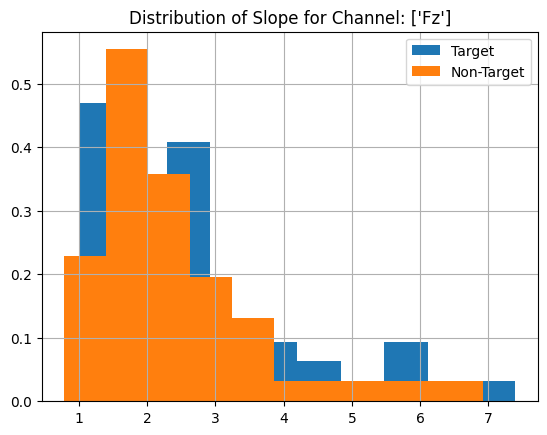

Target Mean: 2.3639145297360558, Std: 1.202074954154117
Non-Target Mean: 2.4353387749455595, Std: 1.1720847301318122
Confidence interval: ConfidenceInterval(low=-0.4697023706839275, high=inf), T-Score: -0.297793, Degree of freedom: 97.93751007092753, P-Value: 0.6167539293930394
With a significance level of 0.05000, the hypothesis is accepted


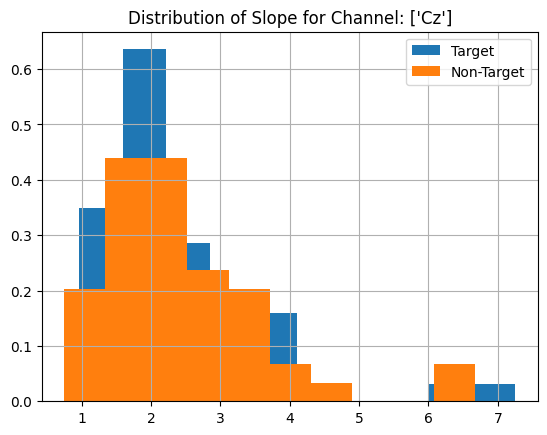

Target Mean: 2.052346425248788, Std: 0.8019028228952647
Non-Target Mean: 1.8908450067364069, Std: 0.6034993775783858
Confidence interval: ConfidenceInterval(low=-0.0767539466985587, high=inf), T-Score: 1.126429, Degree of freedom: 91.0245033612864, P-Value: 0.13147255190240584
With a significance level of 0.05000, the hypothesis is accepted


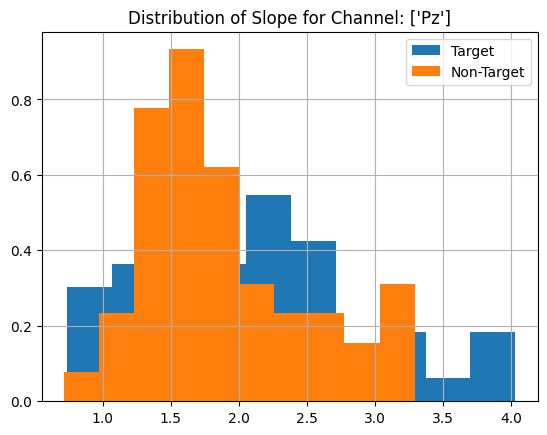

Target Mean: 1.9851983949924386, Std: 0.8763259360222991
Non-Target Mean: 1.991351807673461, Std: 0.5765129063788893
Confidence interval: ConfidenceInterval(low=-0.25536178046038716, high=inf), T-Score: -0.041063, Degree of freedom: 84.72290050250913, P-Value: 0.5163290459633575
With a significance level of 0.05000, the hypothesis is accepted


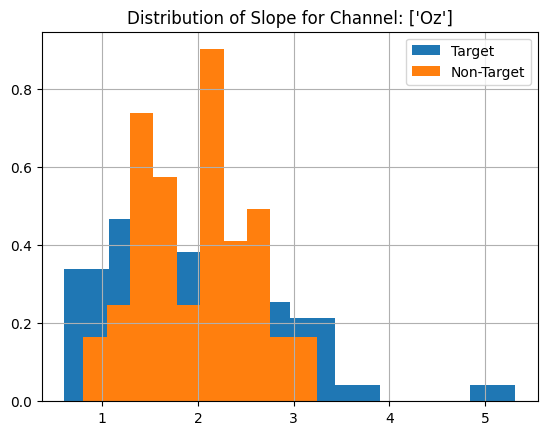

Target Mean: 2.059741589019032, Std: 0.8329649436561131
Non-Target Mean: 2.047874352516368, Std: 0.7612801599343133
Confidence interval: ConfidenceInterval(low=-0.2558438185660537, high=inf), T-Score: 0.073615, Degree of freedom: 97.21694659924326, P-Value: 0.47073381728508934
With a significance level of 0.05000, the hypothesis is accepted


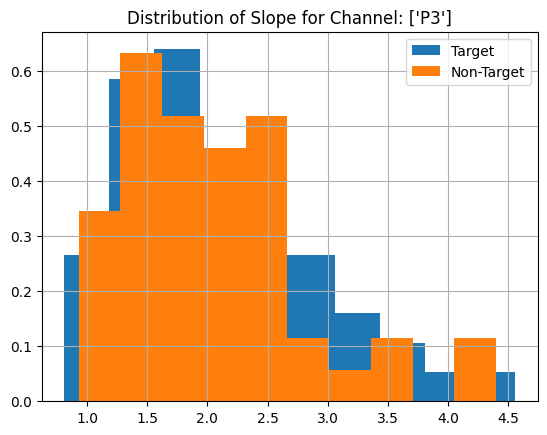

Target Mean: 2.018471985312064, Std: 0.6422897323046315
Non-Target Mean: 2.0534655942940367, Std: 0.7001944899344672
Confidence interval: ConfidenceInterval(low=-0.2604085853713408, high=inf), T-Score: -0.257804, Degree of freedom: 97.27877006777888, P-Value: 0.6014484603287841
With a significance level of 0.05000, the hypothesis is accepted


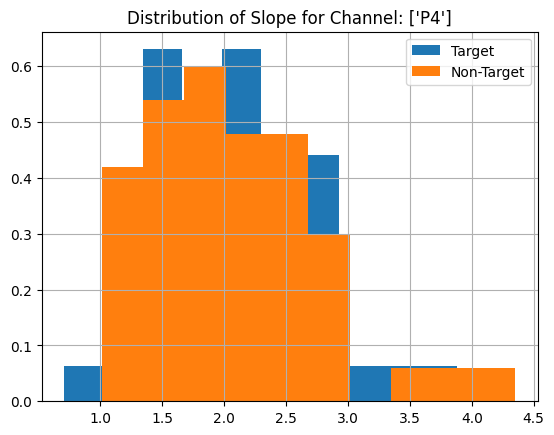

Target Mean: 2.341445068157849, Std: 0.9742234204089852
Non-Target Mean: 2.045366316681506, Std: 0.7345830824143547
Confidence interval: ConfidenceInterval(low=0.00642778717391318, high=inf), T-Score: 1.698628, Degree of freedom: 91.10669075711647, P-Value: 0.04640101824872044
With a significance level of 0.05000, the hypothesis is rejected


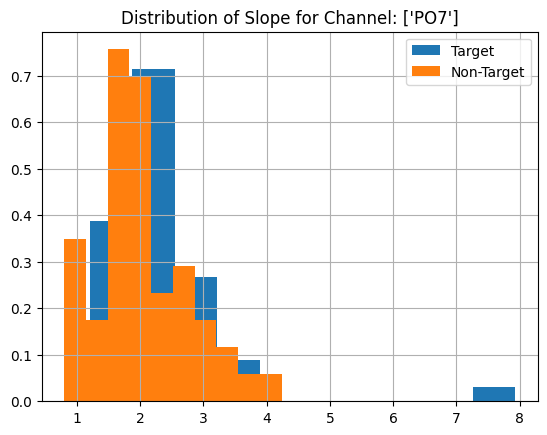

Target Mean: 1.6927051091237637, Std: 0.6551859945480594
Non-Target Mean: 1.6518994412299566, Std: 0.7263598505822838
Confidence interval: ConfidenceInterval(low=-0.19126693177027035, high=inf), T-Score: 0.292007, Degree of freedom: 96.97592426442766, P-Value: 0.3854526740153039
With a significance level of 0.05000, the hypothesis is accepted


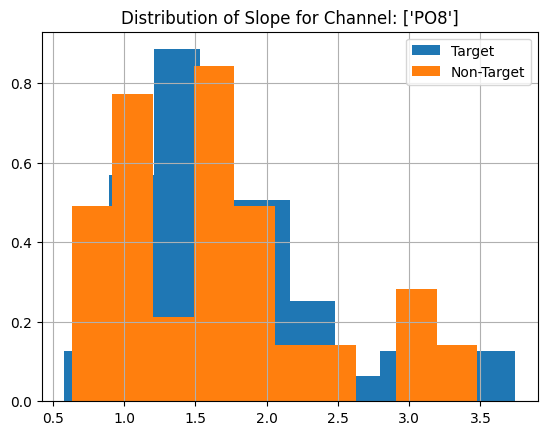

In [56]:
sample_size = 50

np.random.seed(34324)

def view_distribution():
    for channel in range(x_target.shape[1]):
        ma_t = []
        ma_nt = []
        for _ in range(sample_size):
            # Get average waveform from sample
            t = x_target[ np.random.choice(np.arange(x_target.shape[0]), size=1, replace=False), channel, :]
            nt = x_nontarget[ np.random.choice(np.arange(x_nontarget.shape[0]), size=1, replace=False), channel, :] 
            
            # Remove negative portion of average waveform as P300 deflection is positive
            t[t<0] = 0
            nt[nt<0] = 0
            
            # Calculate the average amplitude of each signal
            ma_nt.append(np.mean(nt))
            ma_t.append(np.mean(t))

        mean_target_amplitude = np.mean(ma_t)
        std_target_amplitude = np.std(ma_t)
        
        mean_nontarget_amplitude = np.mean(ma_nt)
        std_nontarget_amplitude = np.std(ma_nt)
        
        print(f"Target Mean: {mean_target_amplitude}, Std: {std_target_amplitude}")
        print(f"Non-Target Mean: {mean_nontarget_amplitude}, Std: {std_nontarget_amplitude}")

        # T-Statistics        
        confidence = 0.95
        d = stats.ttest_ind(ma_t, ma_nt, equal_var=False, alternative='greater')
        print(f"Confidence interval: {d.confidence_interval(confidence)}, T-Score: {d.statistic:.6f}, Degree of freedom: {d.df}, P-Value: {d.pvalue}")
        if d.pvalue > (1-confidence):
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is accepted")
        else:
            print(f"With a significance level of {1-confidence:.5f}, the hypothesis is rejected")
        


        plt.figure()
        plt.title(f"Distribution of Slope for Channel: {get_channel_name(patient_data[0], channel)}")
        plt.hist(ma_t, density=True, label='Target')
        plt.hist(ma_nt, density=True, label='Non-Target')
        plt.grid()
        plt.legend()
        plt.show()
        
        
view_distribution()

Even though the P300 amplitude was significant when we collected a bunch of samples for each class and calculated their average waveforms, it is not significant when we calculate the P300 amplitude of individual amplitude. However, it is significant in Oz channel. Let us check if deep neural networks can perform a better classification. For input we will use the following datasets:



1. **Simple waveform**



2. **Stepwise LDA**




In [57]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

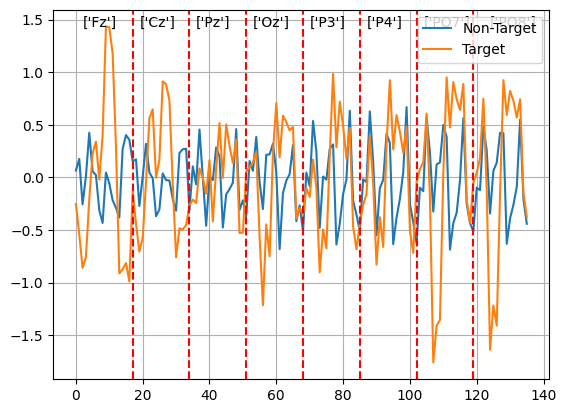

In [58]:
plt.figure()

plt.plot(torch.mean(X_train[np.where(y_train == 0)[0]], axis=0).numpy(), label='Non-Target')
plt.plot(torch.mean(X_train[np.where(y_train == 1)[0]], axis=0).numpy(), label='Target')

a = np.max(torch.mean(X_train[np.where(y_train == 1)[0]], axis=0).numpy())
for i in range(1, 8):
    p = X_train.shape[-1]//8*i
    plt.axvline(x=p, color='red', linestyle='--')
    plt.text(p-15, a, get_channel_name(patient_data[0], i-1))
    if i == 7:
        plt.text(p+5, a, get_channel_name(patient_data[0], i))
        
plt.grid()
plt.legend()

plt.show()

In [59]:
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [60]:
train_dataset = EEGDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [61]:
test_dataset = EEGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [62]:
for data, target in train_loader:
    print(f"Data batch shape: {data.shape}")
    print(f"Target batch shape: {target.shape}")
    break  

Data batch shape: torch.Size([32, 136])
Target batch shape: torch.Size([32])


In [63]:
X_train.shape

torch.Size([8960, 136])

In [64]:
X_train[0].shape

torch.Size([136])

In [65]:
next(iter(train_loader))

[tensor([[-12.7725, -11.0894,  -4.2674,  ...,  -0.5946,  -2.1679,  -4.1312],
         [  3.3694,   0.4934,  -1.4353,  ...,   6.7057,   1.0529, -12.1826],
         [  2.2819,  -3.0388,  -8.0711,  ...,   8.5665,  -1.4853,  -5.6600],
         ...,
         [-17.2883, -24.5443, -16.0873,  ...,  -1.3156,   0.7770,  -9.7664],
         [ -2.8014, -17.7426, -11.0817,  ...,  -5.9695,  -0.5715,   1.6767],
         [  1.1125,   5.3635,   5.9668,  ...,   2.9802,   7.4757,  10.3732]]),
 tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 0, 0, 0, 1])]

### 3. Neural Network Model

In [66]:
epochs = 500
batch_size = 32
learning_rate = 1e-2
learning_rate_decay=0.9
device = 'cuda' if torch.cuda.is_available() else "cpu"
total_classes = np.unique(y_train).size

In [67]:
class DNN(nn.Module):
    def __init__(self, total_classes, input_features, activation: str='ReLU', first_layer_neuron=1024, hidden_layers_neurons=[512, ]):
        super(DNN, self).__init__()
        
        self.fc1 = nn.Linear(input_features, first_layer_neuron)
        
        if activation == 'Tanh':
            self.act1 = nn.Tanh()
        else:
            self.act1 = nn.ReLU()
            
        self.drop1 = nn.Dropout(0.4)
        
        self.layer1 = nn.Sequential(self.fc1, self.act1, self.drop1)
        
        self.hidden_layers = nn.ModuleList()
        in_features = first_layer_neuron
        for neurons in hidden_layers_neurons:
            hidden_fc = nn.Linear(in_features, neurons)
            hidden_act = nn.ReLU()
            hidden_drop = nn.Dropout(0.2)
            self.hidden_layers.append(nn.Sequential(hidden_fc, hidden_act, hidden_drop))
            in_features = neurons

        self.out_fc = nn.Linear(in_features, total_classes)
        
    def forward(self, x):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop1(x)

        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)

        x = self.out_fc(x)
        # pred = torch.argmax(x, dim=1)
        return x
       
    def show_output_distribution(self, x):
        self.eval()
        with torch.no_grad():
            out = self.get_valid_x(x)
            activated_outs = []
            for i in range(len(self.layers)):
                module = self.layers[i]
                for layer in module:
                    out = layer(out)
                    if type(layer).__name__ == self.activation_layer_name[i]:
                        activated_outs.append(out)
                
            cols = 2
            rows = len(activated_outs)/2
            if int(rows) != rows:
                rows = int(rows) + 1
            else:
                rows = int(rows)

            fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
            plt.suptitle("Activated Output distribution")
            
            current = 0
            for i in range(rows):
                for j in range(cols):
                    if current >= len(activated_outs):
                        break
                    ax[i, j].set_title(f"Output: {current+1}")
                    ax[i, j].hist(activated_outs[current].detach().numpy().reshape(-1))
                    ax[i, j].grid()
                    current += 1


            plt.subplots_adjust(hspace=0.5)
            plt.show()
            
            
        self.train()

In [68]:
import torch.nn.functional as F

class DNNModule(pl.LightningModule):
    def __init__(self, total_classes, input_features, activation, first_layer_neuron, hidden_layers_neurons):
        super().__init__()
        self.net = DNN(total_classes, input_features, activation, first_layer_neuron=512, hidden_layers_neurons=[128, 64, 32, 16])
    
        self.train_acc = 0
        self.test_acc = 0
        self.train_acc_epoch = 0
        self.test_acc_epoch = 0
        self.num_train_batches = 0
        self.num_test_batches = 0
        
    def forward(self, x):
        return self.net(x)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.train_acc += (y_hat.argmax(dim=1) == y).float().mean()
        self.num_train_batches += 1
        
        return loss

    def on_train_epoch_end(self):
        avg_train_acc = self.train_acc / self.num_train_batches
        self.log("train_acc", avg_train_acc, on_epoch=True, prog_bar=True)
        self.train_acc = 0
        self.num_train_batches = 0

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.test_acc += (y_hat.argmax(dim=1) == y).float().mean()
        self.num_test_batches += 1
        
        return loss

    def on_test_epoch_end(self):
        avg_test_acc = self.test_acc / self.num_test_batches
        self.log('test_acc', avg_test_acc, on_epoch=True, prog_bar=True)
        
        self.test_acc = 0
        self.num_test_batches = 0

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
        
    def show_weight_distribution(self):
        params = [param for param in self.parameters() if len(param.shape) >= 2]
        cols = 2
        rows = (len(params) + 1) // 2
        
        fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
        plt.suptitle("Weight Distribution")

        current = 0
        for i in range(rows):
            for j in range(cols):
                if current >= len(params):
                    break
                ax[i, j].set_title(f"Param: {current+1}")
                ax[i, j].hist(params[current].detach().numpy().reshape(-1))
                ax[i, j].grid()
                current += 1


        plt.subplots_adjust(hspace=0.5)
        plt.show()
        
    def show_weights(self):
        self.eval()
        with torch.no_grad():
            cols = 2
            rows = len(self.net.layers)//cols
            if rows * cols < len(self.net.layers):
                rows += 1

            fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
            plt.suptitle("Layer Weights")

            current = 0
            current_i = 0
            current_j = 0
            for layer in self.net.layers:
                if current >= len(self.net.layers):
                    break
                params = layer.parameters()
                for p in params:
                    if current >= len(self.net.layers):
                        break
                    if len(p.shape) == 2:
                        weights = p.detach().numpy()
                        ax[current_i, current_j].set_title(f"Weight - Layer {current+1}")
                        im = ax[current_i, current_j].pcolormesh(weights, cmap='gray')
                        fig.colorbar(im, ax=ax[current_i, current_j], orientation='vertical')
                        
                        # Draw vertical line where neurons are dead
                        zeros = np.where(np.sum(weights, axis = 0) == 0)[0]
                        for ind in zeros:
                            ax[current_i, current_j].axvline(x=ind, color='b')
                        current += 1
                        if current_j + 1 >= cols:
                            current_j = 0
                            current_i += 1
                        else:
                            current_j += 1

            
            plt.subplots_adjust(hspace=0.5)
            plt.show()
            
        self.train()

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(params=self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_decay)
      
        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "train_loss",
           },
        }

In [69]:
checkpoint_callback = ModelCheckpoint(
   dirpath="checkpoints",
   monitor="train_loss",
   filename="brain-{epoch:02d}-{train_loss:.2f}-{train_acc:.2f}",
   save_top_k=3,
   mode="min",
)

In [70]:
# Get the current date and time
current_datetime = datetime.now(timezone("UTC")).strftime("%Y-%m-%d_%H-%M-%S")

# Initialize the WandbLogger
logger = WandbLogger(project="ERP", name=f"run-{current_datetime}", tags= ["p300"])

In [71]:
early_stopping = EarlyStopping(monitor="train_loss", patience=10, mode="min", verbose=True)

### 4. Classification - Simple Waveform

In [72]:
import time
model = DNNModule(total_classes, input_features=136, activation="ReLU", first_layer_neuron=1024, hidden_layers_neurons=[128, 64, 32, 16]).to(device)
trainer = pl.Trainer(
    max_epochs=500,
    logger=logger,
    callbacks = [checkpoint_callback, early_stopping],
    accumulate_grad_batches=2,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
)
# Thời gian huấn luyện
start_time = time.time()
trainer.fit(model, train_dataloaders=train_loader)
end_time = time.time()
total_training_time = end_time - start_time
wandb.log({'Total training time': total_training_time})

test_time = time.time()
trainer.test(dataloaders=test_loader)
end_test_time = time.time()
total_test_time = end_test_time - test_time
wandb.log({'Total test time': total_training_time})

logger.experiment.save("checkpoints/*.ckpt")
wandb.finish()

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │          0.6875           │
│      test_loss_epoch      │    0.5994507670402527     │
└───────────────────────────┴───────────────────────────┘

wandb: WARNING Symlinked 61 files into the W&B run directory, call wandb.save again to sync new files.


### 5. Classification - Stepwise LDA (35 features)

In [73]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train.numpy(), y_train.numpy())

In [74]:
# thực hiện tiền xử lý dữ liệu - Stepwise
X_lda_train, X_lda_test = torch.tensor(lda.transform(X_train.numpy()).real).float(), torch.tensor(lda.transform(X_test.numpy()).real).float()

In [75]:
lda_train_dataset = EEGDataset(X_lda_train, y_train)
lda_train_loader = DataLoader(lda_train_dataset, batch_size = 32, shuffle = True)

In [76]:
lda_test_dataset = EEGDataset(X_lda_test, y_test)
lda_test_loader = DataLoader(lda_test_dataset, batch_size = 32, shuffle = True)

In [77]:
X_lda_train.shape

torch.Size([8960, 35])

In [78]:
next(iter(lda_train_loader))

[tensor([[-2.4386, -0.4227, -0.2656,  ..., -0.8324,  0.8407,  2.8237],
         [-1.3400,  0.1002,  1.0070,  ...,  0.0627, -0.2537, -0.3681],
         [-0.4548,  0.3353,  0.9029,  ...,  1.2131, -2.5721,  0.4429],
         ...,
         [-2.9241,  0.1886,  0.8239,  ...,  1.2630, -0.5742, -0.6254],
         [ 0.2822,  0.6777,  0.3377,  ..., -0.2441, -0.9092, -0.4522],
         [ 0.2929, -1.3812,  0.9921,  ..., -2.5438,  0.1934,  0.2833]]),
 tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
         0, 0, 0, 1, 1, 0, 1, 1])]

In [79]:
epochs = 50
batch_size = 32
learning_rate = 1e-3
learning_rate_decay=0.95

In [80]:
checkpoint_callback = ModelCheckpoint(
   dirpath="checkpoints",
   monitor="train_loss",
   filename="brain-{epoch:02d}-{train_loss:.2f}-{train_acc:.2f}",
   save_top_k=3,
   mode="min",
)
# Get the current date and time
current_datetime = datetime.now(timezone("UTC")).strftime("%Y-%m-%d_%H-%M-%S")

# Initialize the WandbLogger
logger = WandbLogger(project="ERP", name=f"run-{current_datetime}", tags= ["p300"])

In [81]:
early_stopping = EarlyStopping(monitor="train_loss", patience=10, mode="min", verbose=True)

In [82]:
import time
model2 = DNNModule(total_classes, input_features=35, activation='Tanh', first_layer_neuron=512, hidden_layers_neurons=[128, 64, 32, 16]).to(device)
trainer = pl.Trainer(
    max_epochs=50,
    logger=logger,
    callbacks = [checkpoint_callback, early_stopping],
    accumulate_grad_batches=2,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
)
# Thời gian huấn luyện
start_time = time.time()
trainer.fit(model2, train_dataloaders=lda_train_loader)
end_time = time.time()
total_training_time = end_time - start_time
wandb.log({'Total training time': total_training_time})

test_time = time.time()
trainer.test(dataloaders=lda_test_loader)
end_test_time = time.time()
total_test_time = end_test_time - test_time
wandb.log({'Total test time': total_training_time})

logger.experiment.save("checkpoints/*.ckpt")
wandb.finish()

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7133928537368774     │
│      test_loss_epoch      │    0.6052965521812439     │
└───────────────────────────┴───────────────────────────┘

wandb: WARNING Symlinked 64 files into the W&B run directory, call wandb.save again to sync new files.


Deep Neural Networks also provide a classification accuracy over 97\%. DNNs perform much better than RFC. However, if we reduce the dimensionality using Stepwise LDA, we obtain similar accuracy as the raw signal but we gain an increase in speed of classification.





## Classification using Pz, Oz, PO7, and PO8



Earlier we saw that the statistical significance of P300 amplitude was prominent in parietal and occipital region. Therefore, we will now use the data of these channels only to perform classification using Neural Networks and Stepwise LDA.



### Create Dataset

In [83]:
total_samples_per_class = 17*12 # Number of samples in each waveform
additional_samples = total_samples_per_class - int(256*stimulus_duration/1000) # Additional sample
x, y = create_dataset(X_filtered, y_target, get_delayed_samples=additional_samples, show_progress=True)
y = y - 1
print(x.shape)

# Bring channel to second axis for ease of visualization
x = x.transpose((0, 2, 1))

cnames = ['Pz', 'Oz', 'PO7', 'PO8']
c = []
for n in cnames:
    c.append(get_channel_index(patient_data[0], n))

x = x[:, c, :] # Only use Oz, PO7, and PO8 channel

# Calculate average of consecutive 12 samples to get a sample of size 17x8
x = x.reshape((x.shape[0], x.shape[1], 17, 12)).mean(axis=-1)
x, y = shuffle(x, y, random_state=12432)
X_data = x.copy()
y_data = y.copy()
x = x.reshape((x.shape[0], -1))
print(x.shape)

100%|██████████| 267680/267680 [00:00<00:00, 571821.40it/s]


(33576, 204, 8)
(33576, 68)


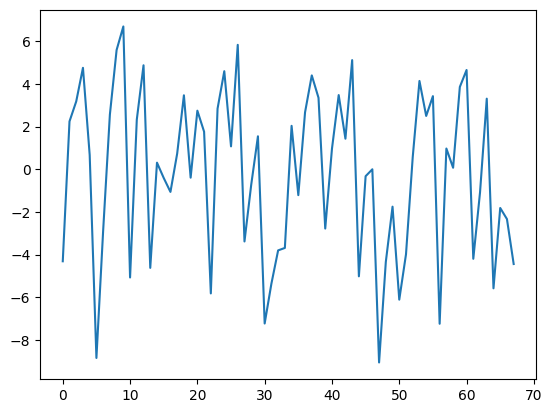

In [84]:
plt.figure()
plt.plot(x[2, :])
plt.show()

In [85]:
np.unique(y)

array([0, 1], dtype=uint8)

In [86]:
# Balancing the dataset
data_per_class = 5600
indices = np.concatenate((np.where(y == 0)[0][:data_per_class], np.where(y == 1)[0][:data_per_class]))
x = x[indices, :]
y = y[indices]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6150)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8960, 68) (8960,) (2240, 68) (2240,)


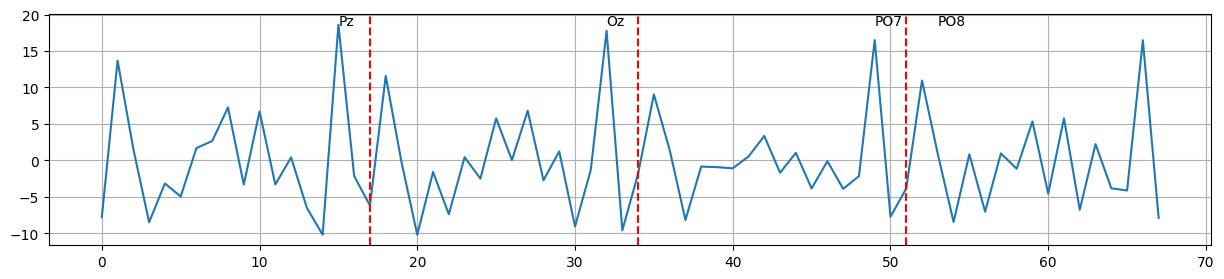

In [88]:
plt.figure(figsize=(15, 3))
plt.plot(x[0, :])
a = np.max(x[0])
for i in range(1, X_data.shape[1]):
    p = x.shape[-1]//X_data.shape[1]*i
    plt.axvline(x=p, color='red', linestyle='--')
    plt.text(p-2, a, cnames[i-1])
    if i == X_data.shape[1]-1:
        plt.text(p+2, a, cnames[i])
plt.grid()
plt.show()

### Stepwise LDA Visualization

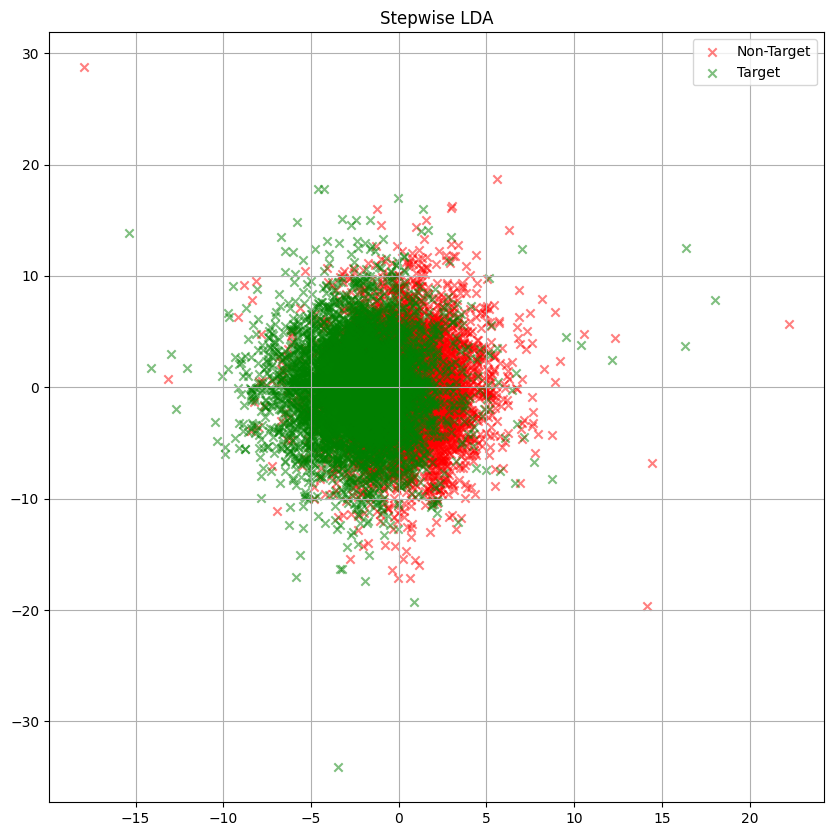

In [89]:
a =  StepwiseLDA(n_components=2).fit(x, y).transform(x)
plt.figure(figsize=(10, 10))
plt.title("Stepwise LDA")
plt.scatter(a[y == 0, 0].real, a[y == 0, 1].real, label='Non-Target', color='r', alpha=0.5, marker='x')
plt.scatter(a[y == 1, 0].real, a[y == 1, 1].real, label='Target', color='g', alpha=0.5, marker='x')
plt.grid()
plt.legend()
plt.show()

### Classification - DNN model

In [90]:
lda = StepwiseLDA(n_components=35)
lda.fit(X_train, y_train)

In [93]:
# thực hiện tiền xử lý dữ liệu - Stepwise
X_lda_train, X_lda_test = torch.tensor(lda.transform(X_train).real).float(), torch.tensor(lda.transform(X_test).real).float()

In [94]:
lda_train_dataset = EEGDataset(X_lda_train, y_train)
lda_train_loader = DataLoader(lda_train_dataset, batch_size = 32, shuffle = True)

In [95]:
lda_test_dataset = EEGDataset(X_lda_test, y_test)
lda_test_loader = DataLoader(lda_test_dataset, batch_size = 32, shuffle = True)

In [96]:
lda_train_dataset

In [97]:
checkpoint_callback = ModelCheckpoint(
   dirpath="checkpoints",
   monitor="train_loss",
   filename="brain-{epoch:02d}-{train_loss:.2f}-{train_acc:.2f}",
   save_top_k=3,
   mode="min",
)
# Get the current date and time
current_datetime = datetime.now(timezone("UTC")).strftime("%Y-%m-%d_%H-%M-%S")

# Initialize the WandbLogger
logger = WandbLogger(project="ERP", name=f"run-{current_datetime}", tags= ["p300"])

In [98]:
early_stopping = EarlyStopping(monitor="train_loss", patience=10, mode="min", verbose=True)

In [99]:
epochs = 100
batch_size = 32
learning_rate = 1e-3
learning_rate_decay=0.95

In [100]:
import time
model3 = DNNModule(total_classes, input_features=35, activation='Tanh', first_layer_neuron=128, hidden_layers_neurons=[64, 32, 16]).to(device)
trainer = pl.Trainer(
    max_epochs=100,
    logger=logger,
    callbacks = [checkpoint_callback, early_stopping],
    accumulate_grad_batches=2,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices="auto",
)
# Thời gian huấn luyện
start_time = time.time()
trainer.fit(model3, train_dataloaders=lda_train_loader)
end_time = time.time()
total_training_time = end_time - start_time
wandb.log({'Total training time': total_training_time})

test_time = time.time()
trainer.test(dataloaders=lda_test_loader)
end_test_time = time.time()
total_test_time = end_test_time - test_time
wandb.log({'Total test time': total_training_time})

logger.experiment.save("checkpoints/*.ckpt")
wandb.finish()

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7093750238418579     │
│      test_loss_epoch      │    0.6017432808876038     │
└───────────────────────────┴───────────────────────────┘

wandb: WARNING Symlinked 67 files into the W&B run directory, call wandb.save again to sync new files.


# EEGNET